## Create non IID dataset with different frequencies

In [1]:
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/fl4tsf'
BIN_DIR = f'{ROOT_DIR}/bin'
DATA_DIR = f'{ROOT_DIR}/data'
import os
import sys
sys.path.append(ROOT_DIR)
sys.path.append(BIN_DIR)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from collections import Counter
from matplotlib import cm
from torch.distributions import uniform
import pandas as pd
import seaborn as sns
import sys
import json
import glob
import os 
# Ensure seaborn theme
sns.set_theme(style='whitegrid')
from lib.dataset_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
import neurokit3 as nk
from typing import List, Tuple, Optional
from pathlib import Path

# Data v3

In [5]:
import wfdb
import ast
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(f'{path}/{f}') for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(f'{path}/{f}') for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = f"{DATA_DIR}/ecg_physionet"
sampling_rate = 100
Y = pd.read_csv(f"{DATA_DIR}/ecg_physionet/ptbxl_database.csv", index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

columns = ['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker','filename_lr', 'filename_hr']
Y = Y[columns]
Y['recording_date'] = pd.to_datetime(Y['recording_date'])
X = load_raw_data(Y, sampling_rate, path)

In [ ]:
data = np.load(f'{DATA_DIR}/ecg_physionet/data_raw_emb_large.npy', allow_pickle=True).item()
Y = data['metadata']
X_raw = data['raw']
X_emb = data['emb']

In [33]:
import numpy as np
import pandas as pd

# Load data
data = np.load(f'{DATA_DIR}/ecg_physionet/data_raw_emb_large.npy', allow_pickle=True).item()
Y = data['metadata']
X_raw = data['raw']
X_emb = data['emb']

print(f"Original shapes - Y: {Y.shape}, X_raw: {X_raw.shape}, X_emb: {X_emb.shape}")

# Store original indices to track alignment
original_indices = Y.index.copy()

# Filter Y - step 1: dropna
Y = Y.dropna(subset=['scp_codes', 'site'])

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(f'{path}/scp_statements.csv', index_col=0)
agg_df = agg_df[(agg_df.diagnostic == 1) | (agg_df.index.isin(['AFIB', 'PACE', 'AFLT']))]
agg_df['diagnostic_class'] = agg_df['diagnostic_class'].fillna(agg_df.index.to_series())

# Create fast lookup dictionary
code_to_class = agg_df['diagnostic_class'].to_dict()
valid_codes = set(code_to_class.keys())
all_diagnostic_classes = sorted(agg_df['diagnostic_class'].unique())

def fast_aggregate_diagnostic_wide(y_dic):
    """Return a dictionary with binary indicators for each diagnostic class."""
    # Handle NaN or non-dict values
    if not isinstance(y_dic, dict) or pd.isna(y_dic):
        return {cls: 0 for cls in all_diagnostic_classes}
    
    # Filter out codes with score < 50
    filtered_dic = {k: v for k, v in y_dic.items() if v >= 50}
    
    # If 'NORM' is present and there are other codes, drop 'NORM'
    if 'NORM' in filtered_dic and len(filtered_dic) > 1:
        del filtered_dic['NORM']
    
    # Map to diagnostic classes
    matching_codes = set(filtered_dic.keys()) & valid_codes
    present_classes = {code_to_class[code] for code in matching_codes}
    
    # Create binary indicator dictionary
    return {cls: 1 if cls in present_classes else 0 for cls in all_diagnostic_classes}

# Apply the function and convert to DataFrame
diagnostic_wide = Y.scp_codes.apply(fast_aggregate_diagnostic_wide)

# Convert to DataFrame
diagnostic_df = pd.DataFrame(diagnostic_wide.tolist(), index=Y.index)
diagnostic_df.columns = [f'diag_{col}' for col in diagnostic_df.columns]
Y_with_diagnostics = pd.concat([Y, diagnostic_df], axis=1)

# Filter out rows with no diagnostics
diagnostic_cols = [
    'diag_AFIB', 'diag_AFLT', 'diag_CD', 'diag_HYP', 'diag_MI',
    'diag_NORM', 'diag_PACE', 'diag_STTC',
]
Y_with_diagnostics = Y_with_diagnostics[Y_with_diagnostics[diagnostic_cols].sum(axis=1) > 0]

print(f"Filtered Y shape: {Y_with_diagnostics.shape}")

# FILTER X_raw and X_emb to match filtered Y
# Get the positions of kept indices in the original array
kept_indices = Y_with_diagnostics.index
original_positions = pd.Series(range(len(original_indices)), index=original_indices)
array_positions = original_positions.loc[kept_indices].values

# Filter the arrays
X_raw_filtered = X_raw[array_positions]
X_emb_filtered = X_emb[array_positions]

print(f"Filtered shapes - Y: {Y_with_diagnostics.shape}, X_raw: {X_raw_filtered.shape}, X_emb: {X_emb_filtered.shape}")

# Verify alignment by checking a few samples
print("\nVerification - checking alignment:")
for i in range(min(3, len(Y_with_diagnostics))):
    y_index = Y_with_diagnostics.index[i]
    original_pos = array_positions[i]
    print(f"Row {i}: Y index = {y_index}, Array position = {original_pos}")

# Final data - all aligned
Y_final = Y_with_diagnostics
X_raw_final = X_raw_filtered  
X_emb_final = X_emb_filtered

print(f"\nFinal aligned data:")
print(f"Y_final: {Y_final.shape}")
print(f"X_raw_final: {X_raw_final.shape}")  
print(f"X_emb_final: {X_emb_final.shape}")

Original shapes - Y: (21799, 22), X_raw: (21799, 1000, 12), X_emb: (21799, 960)
Filtered Y shape: (20626, 30)
Filtered shapes - Y: (20626, 30), X_raw: (20626, 1000, 12), X_emb: (20626, 960)

Verification - checking alignment:
Row 0: Y index = 1, Array position = 0
Row 1: Y index = 2, Array position = 1
Row 2: Y index = 3, Array position = 2

Final aligned data:
Y_final: (20626, 30)
X_raw_final: (20626, 1000, 12)
X_emb_final: (20626, 960)


In [34]:
site_summary = (
    Y_with_diagnostics.groupby('site')
    .agg(
        total_cases=('patient_id', 'count'), 
        unique_nurses=('nurse', pd.Series.nunique),
        pacemaker_cases=('pacemaker', lambda x: x.notna().sum()),
        extrabeats_cases=('extra_beats', lambda x: x.notna().sum()),
        baselinedrift_cases=('baseline_drift', lambda x: x.notna().sum()),
        **{col: (col, 'sum') for col in diagnostic_cols}
    )
    .reset_index()
)

site_summary.head()

,site,total_cases,unique_nurses,pacemaker_cases,extrabeats_cases,baselinedrift_cases,diag_AFIB,diag_AFLT,diag_CD,diag_HYP,diag_MI,diag_NORM,diag_PACE,diag_STTC
0,0.0,8395,10,196,811,650,29,30,1752,894,1790,3789,197,1829
1,1.0,6008,10,40,336,301,3,12,1415,756,980,2696,39,1646
2,2.0,4802,1,31,505,407,14,11,1343,399,1043,1906,27,1184
3,3.0,555,0,17,42,98,1,2,158,93,163,144,17,194
4,4.0,98,0,0,4,8,0,0,28,20,23,35,0,32


In [35]:
# Group by device and aggregate
device_summary = (
    Y.groupby('device')
    .agg(
        first_dt=('recording_date', 'min'),
        last_ydt=('recording_date', 'max'),
        sites=('site', lambda x: sorted(set(x)))
    )
    .reset_index()
)
device_summary

,device,first_dt,last_ydt,sites
0,AT-6 6,1987-04-10 11:17:07,1997-10-02 11:37:21,"[0.0, 1.0, 4.0, 7.0, 10.0, 11.0, 13.0, 14.0, 1..."
1,AT-6 C,1986-02-21 11:22:18,1996-03-18 11:50:59,[3.0]
2,AT-6 C 5.0,1985-12-11 13:22:32,1997-08-10 10:54:12,"[0.0, 1.0, 10.0]"
3,AT-6 C 5.3,1987-05-08 15:32:50,1997-07-13 15:19:09,"[1.0, 35.0]"
4,AT-6 C 5.5,1986-09-04 17:54:14,1997-10-02 12:25:54,"[0.0, 1.0, 5.0, 8.0, 9.0, 15.0, 18.0, 21.0, 22..."
5,AT-6 C 5.6,1986-09-14 08:41:05,1997-02-08 18:33:30,[1.0]
6,AT-6 C 5.8,1986-09-06 16:11:01,1997-10-05 21:07:50,"[0.0, 1.0, 6.0, 12.0, 19.0, 23.0, 25.0, 32.0]"
7,AT-60 3,1989-07-09 15:01:09,2001-06-11 16:43:01,[2.0]
8,CS-12,1986-03-27 08:47:57,2000-10-14 18:20:45,[2.0]
9,CS-12 E,1984-11-09 09:17:34,1999-05-04 09:14:37,"[0.0, 3.0, 47.0]"


In [51]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon
from scipy.stats import ks_2samp, energy_distance
import warnings
warnings.filterwarnings('ignore')

class FederatedDataSplitter:
    """
    A class to create different levels of data splits for federated learning,
    ranging from IID baseline to severe non-IID label and feature distribution shifts.
    """
    
    def __init__(self, df: pd.DataFrame, X_raw: Optional[np.ndarray] = None, 
                 X_emb: Optional[np.ndarray] = None):
        """
        Initialize the splitter with the dataset.
        
        Args:
            df: DataFrame with diagnostic columns and site information (Y_with_diagnostics)
            X_raw: Raw ECG data as numpy array (e.g., shape=(21799, 1000, 12)) (optional)
            X_emb: Embedding data as numpy array (e.g., shape=(21799, 960)) (optional)
        """
        self.df = df.copy()
        self.X_raw = X_raw.copy() if X_raw is not None else None
        self.X_emb = X_emb.copy() if X_emb is not None else None
        
        # Verify array dimensions match DataFrame length if provided
        if self.X_raw is not None:
            assert len(self.df) == self.X_raw.shape[0], f"Y length ({len(self.df)}) and X_raw length ({self.X_raw.shape[0]}) must match"
            
        if self.X_emb is not None:
            assert len(self.df) == self.X_emb.shape[0], f"Y length ({len(self.df)}) and X_emb length ({self.X_emb.shape[0]}) must match"
        
        self.diagnostic_cols = [
            'diag_AFIB', 'diag_AFLT', 'diag_CD', 'diag_HYP', 
            'diag_MI', 'diag_NORM', 'diag_PACE', 'diag_STTC'
        ]
        self._create_superclasses()
        
        print(f"Initialized FederatedDataSplitter:")
        print(f"  - Y data: {self.df.shape}")
        print(f"  - X_raw: {self.X_raw.shape if self.X_raw is not None else 'Not provided'}")
        print(f"  - X_emb: {self.X_emb.shape if self.X_emb is not None else 'Not provided'}")
        print()
        
    def _split_features(self, client_1_y: pd.DataFrame, 
                       client_2_y: pd.DataFrame) -> Tuple[Dict, Dict]:
        """
        Split feature data (X_raw, X_emb) according to Y splits.
        
        Args:
            client_1_y: Y data for client 1
            client_2_y: Y data for client 2
            
        Returns:
            Tuple of (client_1_features, client_2_features) dictionaries
        """
        client_1_features = {}
        client_2_features = {}
        
        # Get integer indices for both clients
        client_1_indices = client_1_y.index.tolist()
        client_2_indices = client_2_y.index.tolist()
        
        # Convert DataFrame indices to integer positions for array indexing
        # Assuming the DataFrame index corresponds to array positions
        if hasattr(self.df.index, 'get_indexer'):
            # If we have a custom index, get the positions
            client_1_positions = self.df.index.get_indexer(client_1_indices)
            client_2_positions = self.df.index.get_indexer(client_2_indices)
        else:
            # If index is already integer positions
            client_1_positions = client_1_indices
            client_2_positions = client_2_indices
        
        if self.X_raw is not None:
            client_1_features['X_raw'] = self.X_raw[client_1_positions].copy()
            client_2_features['X_raw'] = self.X_raw[client_2_positions].copy()
        
        if self.X_emb is not None:
            client_1_features['X_emb'] = self.X_emb[client_1_positions].copy()
            client_2_features['X_emb'] = self.X_emb[client_2_positions].copy()
            
        return client_1_features, client_2_features
        
    def _create_superclasses(self):
        """Create diagnostic superclasses as specified."""
        def get_superclass(row):
            if row['diag_NORM'] == 1:
                return 'NORM'
            elif row['diag_MI'] == 1:
                return 'MI'
            elif row['diag_STTC'] == 1:
                return 'STTC'
            elif row['diag_CD'] == 1:
                return 'CD'
            elif row['diag_HYP'] == 1:
                return 'HYP'
            elif row['diag_AFIB'] == 1 or row['diag_AFLT'] == 1:
                return 'AFIB_AFLT'
            elif row['diag_PACE'] == 1:
                return 'PACE'
            else:
                # Handle cases where no diagnosis is positive or multiple are positive
                # Take the first positive diagnosis found
                for diag in self.diagnostic_cols:
                    if row[diag] == 1:
                        return diag.replace('diag_', '')
                return 'UNKNOWN'
        
        self.df['superclass'] = self.df.apply(get_superclass, axis=1)
        print(f"Superclass distribution:")
        print(self.df['superclass'].value_counts())
        print()
        """Create diagnostic superclasses as specified."""
        def get_superclass(row):
            if row['diag_NORM'] == 1:
                return 'NORM'
            elif row['diag_MI'] == 1:
                return 'MI'
            elif row['diag_STTC'] == 1:
                return 'STTC'
            elif row['diag_CD'] == 1:
                return 'CD'
            elif row['diag_HYP'] == 1:
                return 'HYP'
            elif row['diag_AFIB'] == 1 or row['diag_AFLT'] == 1:
                return 'AFIB_AFLT'
            elif row['diag_PACE'] == 1:
                return 'PACE'
            else:
                # Handle cases where no diagnosis is positive or multiple are positive
                # Take the first positive diagnosis found
                for diag in self.diagnostic_cols:
                    if row[diag] == 1:
                        return diag.replace('diag_', '')
                return 'UNKNOWN'
        
        self.df['superclass'] = self.df.apply(get_superclass, axis=1)
        print(f"Superclass distribution:")
        print(self.df['superclass'].value_counts())
        print()
    
    def _pool_data_from_sites(self, sites: List[int] = [0, 1]) -> pd.DataFrame:
        """
        Pool data from specified sites.
        
        Args:
            sites: List of site IDs to pool data from
            
        Returns:
            Pooled DataFrame
        """
        pooled_data = self.df[self.df['site'].isin(sites)].copy()
        print(f"Pooled {len(pooled_data)} samples from sites {sites}")
        return pooled_data
    
    def level_0_iid_baseline(self, sites: List[int] = [0, 1], 
                           random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, Dict, Dict]:
        """
        Level 0: IID Baseline - Purely random split.
        
        Args:
            sites: Sites to pool data from
            random_state: Random seed for reproducibility
            
        Returns:
            Tuple of (client_1_y, client_2_y, client_1_features, client_2_features)
        """
        print("=== LEVEL 0: IID BASELINE ===")
        
        # Pool data from specified sites
        pooled_data = self._pool_data_from_sites(sites)
        
        # Shuffle the pooled data randomly
        shuffled_data = shuffle(pooled_data, random_state=random_state)
        
        # Split data evenly between clients
        mid_point = len(shuffled_data) // 2
        client_1_data = shuffled_data.iloc[:mid_point].copy()
        client_2_data = shuffled_data.iloc[mid_point:].copy()
        
        # Add client IDs
        client_1_data['client_id'] = 1
        client_2_data['client_id'] = 2
        
        # Split features
        client_1_features, client_2_features = self._split_features(client_1_data, client_2_data)
        
        print(f"Client 1: {len(client_1_data)} samples")
        print(f"Client 2: {len(client_2_data)} samples")
        
        self._print_distribution_summary(client_1_data, client_2_data, "IID Baseline")
        
        return client_1_data, client_2_data, client_1_features, client_2_features
    
    def level_1_mild_label_skew(self, sites: List[int] = [0, 1], 
                               alpha: float = 1.0, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, Dict, Dict]:
        """
        Level 1: Controlled, Mild Label Skew using Dirichlet distribution.
        
        Args:
            sites: Sites to pool data from
            alpha: Concentration parameter for Dirichlet (higher = more balanced)
            random_state: Random seed for reproducibility
            
        Returns:
            Tuple of (client_1_y, client_2_y, client_1_features, client_2_features)
        """
        print(f"=== LEVEL 1: MILD LABEL SKEW (alpha={alpha}) ===")
        
        return self._dirichlet_split(sites, alpha, random_state, "Mild Label Skew")
    
    def level_2_severe_label_skew(self, sites: List[int] = [0, 1], 
                                 alpha: float = 0.1, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, Dict, Dict]:
        """
        Level 2: Controlled, Severe Label Skew using Dirichlet distribution.
        
        Args:
            sites: Sites to pool data from
            alpha: Concentration parameter for Dirichlet (lower = more skewed)
            random_state: Random seed for reproducibility
            
        Returns:
            Tuple of (client_1_y, client_2_y, client_1_features, client_2_features)
        """
        print(f"=== LEVEL 2: SEVERE LABEL SKEW (alpha={alpha}) ===")
        
        return self._dirichlet_split(sites, alpha, random_state, "Severe Label Skew")
    
    def _dirichlet_split(self, sites: List[int], alpha: float, 
                        random_state: int, split_name: str) -> Tuple[pd.DataFrame, pd.DataFrame, Dict, Dict]:
        """
        Split data using Dirichlet distribution for label skew.
        
        Args:
            sites: Sites to pool data from
            alpha: Concentration parameter for Dirichlet
            random_state: Random seed
            split_name: Name for logging
            
        Returns:
            Tuple of (client_1_y, client_2_y, client_1_features, client_2_features)
        """
        np.random.seed(random_state)
        
        # Pool data from specified sites
        pooled_data = self._pool_data_from_sites(sites)
        
        # Get unique superclasses
        superclasses = pooled_data['superclass'].unique()
        n_classes = len(superclasses)
        n_clients = 2
        
        print(f"Found {n_classes} superclasses: {superclasses}")
        
        # Generate Dirichlet distribution for each class
        # This determines what proportion of each class goes to each client
        class_distributions = {}
        for superclass in superclasses:
            # Sample from Dirichlet distribution
            proportions = np.random.dirichlet([alpha] * n_clients)
            class_distributions[superclass] = proportions
            print(f"{superclass}: Client 1 gets {proportions[0]:.2%}, Client 2 gets {proportions[1]:.2%}")
        
        # Split data according to the distributions
        client_1_data = []
        client_2_data = []
        
        for superclass in superclasses:
            class_data = pooled_data[pooled_data['superclass'] == superclass].copy()
            class_data = shuffle(class_data, random_state=random_state)
            
            n_samples = len(class_data)
            n_client_1 = int(n_samples * class_distributions[superclass][0])
            
            client_1_class = class_data.iloc[:n_client_1].copy()
            client_2_class = class_data.iloc[n_client_1:].copy()
            
            client_1_data.append(client_1_class)
            client_2_data.append(client_2_class)
        
        # Combine all classes for each client
        client_1_data = pd.concat(client_1_data, ignore_index=False)
        client_2_data = pd.concat(client_2_data, ignore_index=False)
        
        # Shuffle within each client to avoid ordering bias
        client_1_data = shuffle(client_1_data, random_state=random_state)
        client_2_data = shuffle(client_2_data, random_state=random_state + 1)
        
        # Add client IDs
        client_1_data['client_id'] = 1
        client_2_data['client_id'] = 2
        
        # Split features
        client_1_features, client_2_features = self._split_features(client_1_data, client_2_data)
        
        print(f"\nClient 1: {len(client_1_data)} samples")
        print(f"Client 2: {len(client_2_data)} samples")
        
        self._print_distribution_summary(client_1_data, client_2_data, split_name)
        
        return client_1_data, client_2_data, client_1_features, client_2_features
    
    def _print_distribution_summary(self, client_1_data: pd.DataFrame, 
                                   client_2_data: pd.DataFrame, split_name: str):
        """Print distribution summary for both clients."""
        print(f"\n{split_name} - Superclass Distribution:")
        print("Client 1:")
        c1_dist = client_1_data['superclass'].value_counts(normalize=True)
        for superclass, prop in c1_dist.items():
            print(f"  {superclass}: {prop:.2%}")
        
        print("Client 2:")
        c2_dist = client_2_data['superclass'].value_counts(normalize=True)
        for superclass, prop in c2_dist.items():
            print(f"  {superclass}: {prop:.2%}")
        print("-" * 50)
    
    def level_3_natural_feature_shift(self, target_size: int = None, 
                                     random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, Dict, Dict]:
        """
        Level 3: "Natural" Feature Shift + Inherent Label Skew.
        Uses the original site-based split without pooling data.
        
        Args:
            target_size: Target number of samples per client (if None, uses all available)
            random_state: Random seed for reproducibility
            
        Returns:
            Tuple of (client_1_y, client_2_y, client_1_features, client_2_features)
        """
        print("=== LEVEL 3: NATURAL FEATURE SHIFT + INHERENT LABEL SKEW ===")
        
        np.random.seed(random_state)
        
        # Get data from each site separately (no pooling)
        site_0_data = self.df[self.df['site'] == 0].copy()
        site_1_data = self.df[self.df['site'] == 1].copy()
        
        print(f"Site 0 data: {len(site_0_data)} samples")
        print(f"Site 1 data: {len(site_1_data)} samples")
        
        # Assign Site 0 to Client 1, Site 1 to Client 2
        client_1_data = site_0_data.copy()
        client_2_data = site_1_data.copy()
        
        # Subsample if target size is specified
        if target_size is not None:
            if len(client_1_data) > target_size:
                client_1_data = client_1_data.sample(n=target_size, random_state=random_state)
                print(f"Subsampled Client 1 to {target_size} samples")
            
            if len(client_2_data) > target_size:
                client_2_data = client_2_data.sample(n=target_size, random_state=random_state + 1)
                print(f"Subsampled Client 2 to {target_size} samples")
        
        # Add client IDs
        client_1_data['client_id'] = 1
        client_2_data['client_id'] = 2
        
        # Split features
        client_1_features, client_2_features = self._split_features(client_1_data, client_2_data)
        
        print(f"\nFinal sizes:")
        print(f"Client 1 (Site 0): {len(client_1_data)} samples")
        print(f"Client 2 (Site 1): {len(client_2_data)} samples")
        
        # Show natural distribution differences between sites
        print(f"\nNatural label distribution differences:")
        self._print_distribution_summary(client_1_data, client_2_data, "Natural Feature Shift")
        
        return client_1_data, client_2_data, client_1_features, client_2_features
    
    def level_4_extreme_combined_non_iid(self, 
                                        client_1_target_dist: Dict[str, float] = None,
                                        client_2_target_dist: Dict[str, float] = None,
                                        target_size: int = 1000,
                                        random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, Dict, Dict]:
        """
        Level 4: Extreme, Combined & Controlled Non-IID.
        Combines feature shift (site-based split) with severe controlled label skew.
        
        Args:
            client_1_target_dist: Target distribution for Client 1 (e.g., {'MI': 0.4, 'CD': 0.4, 'other': 0.2})
            client_2_target_dist: Target distribution for Client 2 (e.g., {'NORM': 0.8, 'other': 0.2})
            target_size: Target number of samples per client
            random_state: Random seed for reproducibility
            
        Returns:
            Tuple of (client_1_y, client_2_y, client_1_features, client_2_features)
        """
        print("=== LEVEL 4: EXTREME COMBINED & CONTROLLED NON-IID ===")
        
        # Default distributions if not provided (example scenario from description)
        if client_1_target_dist is None:
            client_1_target_dist = {
                'MI': 0.4,
                'CD': 0.4, 
                'other': 0.2  # Everything else
            }
        
        if client_2_target_dist is None:
            client_2_target_dist = {
                'NORM': 0.8,
                'other': 0.2  # Everything else
            }
        
        print(f"Client 1 target distribution: {client_1_target_dist}")
        print(f"Client 2 target distribution: {client_2_target_dist}")
        
        np.random.seed(random_state)
        
        # Start with site-based split (like Level 3)
        site_0_data = self.df[self.df['site'] == 0].copy()
        site_1_data = self.df[self.df['site'] == 1].copy()
        
        print(f"\nStarting with site split:")
        print(f"Site 0 data: {len(site_0_data)} samples")
        print(f"Site 1 data: {len(site_1_data)} samples")
        
        # Apply controlled label skew to each client's site data
        client_1_data = self._apply_label_skew(site_0_data, client_1_target_dist, 
                                             target_size, random_state, "Client 1 (Site 0)")
        
        client_2_data = self._apply_label_skew(site_1_data, client_2_target_dist, 
                                             target_size, random_state + 1, "Client 2 (Site 1)")
        
        # Add client IDs
        client_1_data['client_id'] = 1
        client_2_data['client_id'] = 2
        
        # Split features
        client_1_features, client_2_features = self._split_features(client_1_data, client_2_data)
        print(f"\nFinal sizes:")
        print(f"Client 1: {len(client_1_data)} samples")
        print(f"Client 2: {len(client_2_data)} samples")
        
        self._print_distribution_summary(client_1_data, client_2_data, "Extreme Combined Non-IID")
        
        return client_1_data, client_2_data, client_1_features, client_2_features
    
    def _apply_label_skew(self, site_data: pd.DataFrame, target_dist: Dict[str, float], 
                         target_size: int, random_state: int, client_name: str) -> pd.DataFrame:
        """
        Apply controlled label skew to site data based on target distribution.
        
        Args:
            site_data: Data from a specific site
            target_dist: Target distribution (e.g., {'MI': 0.4, 'CD': 0.4, 'other': 0.2})
            target_size: Target number of samples
            random_state: Random seed
            client_name: Name for logging
            
        Returns:
            Skewed dataset
        """
        np.random.seed(random_state)
        
        print(f"\n{client_name} - Applying label skew:")
        
        # Get available superclasses in this site's data
        available_classes = site_data['superclass'].unique()
        print(f"Available classes in site data: {available_classes}")
        
        # Calculate target sample counts for each class
        target_counts = {}
        remaining_samples = target_size
        
        # Handle specific classes first
        for class_name, proportion in target_dist.items():
            if class_name != 'other':
                target_count = int(target_size * proportion)
                target_counts[class_name] = target_count
                remaining_samples -= target_count
        
        # Handle 'other' category (all remaining classes)
        if 'other' in target_dist:
            other_classes = [c for c in available_classes if c not in target_counts.keys()]
            if other_classes:
                # Distribute remaining samples among 'other' classes
                samples_per_other_class = remaining_samples // len(other_classes)
                remainder = remaining_samples % len(other_classes)
                
                for i, class_name in enumerate(other_classes):
                    count = samples_per_other_class
                    if i < remainder:  # Distribute remainder
                        count += 1
                    target_counts[class_name] = count
        
        print(f"Target counts: {target_counts}")
        
        # Sample data according to target distribution
        sampled_data = []
        
        for class_name, target_count in target_counts.items():
            if target_count == 0:
                continue
                
            class_data = site_data[site_data['superclass'] == class_name]
            
            if len(class_data) == 0:
                print(f"Warning: No samples available for class {class_name} in site data")
                continue
            
            if len(class_data) < target_count:
                print(f"Warning: Only {len(class_data)} samples available for {class_name}, "
                     f"target was {target_count}. Using all available.")
                sampled_class_data = class_data
            else:
                sampled_class_data = class_data.sample(n=target_count, random_state=random_state)
            
            sampled_data.append(sampled_class_data)
            print(f"  {class_name}: sampled {len(sampled_class_data)} samples")
        
        # Combine all sampled data
        if sampled_data:
            result_data = pd.concat(sampled_data, ignore_index=False)
            # Shuffle to avoid ordering bias
            result_data = shuffle(result_data, random_state=random_state)
        else:
            result_data = pd.DataFrame()
            print(f"Warning: No data sampled for {client_name}")
        
        return result_data



    def level_5_site_temporal_split(self, 
                                   client_1_site: int = 0, 
                                   client_2_site: int = 1,
                                   client_1_date_range: Tuple[str, str] = ('1995-01-01', None),
                                   client_2_date_range: Tuple[str, str] = (None, '1993-01-01'),
                                   target_size: int = None,
                                   random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, Dict, Dict]:
        """
        Level 5: Site + Temporal Split.
        Combines site-based split with temporal distribution shift.
        
        Args:
            client_1_site: Site ID for Client 1
            client_2_site: Site ID for Client 2  
            client_1_date_range: Date range for Client 1 as (start_date, end_date). 
                                 None means no bound in that direction.
            client_2_date_range: Date range for Client 2 as (start_date, end_date).
                                 None means no bound in that direction.
            target_size: Target number of samples per client (if None, uses all available)
            random_state: Random seed for reproducibility
            
        Returns:
            Tuple of (client_1_y, client_2_y, client_1_features, client_2_features)
        """
        print("=== LEVEL 5: SITE + TEMPORAL SPLIT ===")
        
        np.random.seed(random_state)
        
        # Convert date strings to datetime if needed
        def parse_date_range(date_range):
            start_date, end_date = date_range
            start_date = pd.to_datetime(start_date) if start_date else None
            end_date = pd.to_datetime(end_date) if end_date else None
            return start_date, end_date
        
        client_1_start, client_1_end = parse_date_range(client_1_date_range)
        client_2_start, client_2_end = parse_date_range(client_2_date_range)
        
        print(f"Client 1: Site {client_1_site}, Date range: {client_1_start} to {client_1_end}")
        print(f"Client 2: Site {client_2_site}, Date range: {client_2_start} to {client_2_end}")
        
        # Ensure recording_date is datetime
        df_temp = self.df.copy()
        if 'recording_date' in df_temp.columns:
            df_temp['recording_date'] = pd.to_datetime(df_temp['recording_date'])
        else:
            raise ValueError("recording_date column not found in data")
        
        # Filter Client 1 data (site + temporal)
        client_1_data = df_temp[df_temp['site'] == client_1_site].copy()
        
        if client_1_start is not None:
            client_1_data = client_1_data[client_1_data['recording_date'] >= client_1_start]
        if client_1_end is not None:
            client_1_data = client_1_data[client_1_data['recording_date'] < client_1_end]
        
        # Filter Client 2 data (site + temporal)  
        client_2_data = df_temp[df_temp['site'] == client_2_site].copy()
        
        if client_2_start is not None:
            client_2_data = client_2_data[client_2_data['recording_date'] >= client_2_start]
        if client_2_end is not None:
            client_2_data = client_2_data[client_2_data['recording_date'] < client_2_end]
        
        print(f"\nAfter site + temporal filtering:")
        print(f"Client 1: {len(client_1_data)} samples")
        print(f"Client 2: {len(client_2_data)} samples")
        
        # Show date ranges in the filtered data
        if len(client_1_data) > 0:
            c1_date_range = (client_1_data['recording_date'].min(), client_1_data['recording_date'].max())
            print(f"Client 1 actual date range: {c1_date_range[0].date()} to {c1_date_range[1].date()}")
        
        if len(client_2_data) > 0:
            c2_date_range = (client_2_data['recording_date'].min(), client_2_data['recording_date'].max())
            print(f"Client 2 actual date range: {c2_date_range[0].date()} to {c2_date_range[1].date()}")
        
        # Subsample if target size is specified
        if target_size is not None:
            if len(client_1_data) > target_size:
                client_1_data = client_1_data.sample(n=target_size, random_state=random_state)
                print(f"Subsampled Client 1 to {target_size} samples")
            
            if len(client_2_data) > target_size:
                client_2_data = client_2_data.sample(n=target_size, random_state=random_state + 1)
                print(f"Subsampled Client 2 to {target_size} samples")
        
        # Add client IDs
        client_1_data['client_id'] = 1
        client_2_data['client_id'] = 2
        
        # Split features
        client_1_features, client_2_features = self._split_features(client_1_data, client_2_data)
        
        print(f"\nFinal sizes:")
        print(f"Client 1 (Site {client_1_site}): {len(client_1_data)} samples")
        print(f"Client 2 (Site {client_2_site}): {len(client_2_data)} samples")
        
        # Show both site and temporal distribution differences
        print(f"\nSite + Temporal distribution differences:")
        self._print_distribution_summary(client_1_data, client_2_data, "Site + Temporal Split")
        
        # Additional temporal analysis
        self._print_temporal_analysis(client_1_data, client_2_data)
        
        return client_1_data, client_2_data, client_1_features, client_2_features
    
    def _print_temporal_analysis(self, client_1_data: pd.DataFrame, client_2_data: pd.DataFrame):
        """Print temporal characteristics of the split."""
        print(f"\nTemporal Analysis:")
        
        if len(client_1_data) > 0:
            c1_years = client_1_data['recording_date'].dt.year
            print(f"Client 1 years: {c1_years.min()}-{c1_years.max()} (span: {c1_years.max() - c1_years.min()} years)")
            print(f"Client 1 year distribution: {c1_years.value_counts().head().to_dict()}")
        
        if len(client_2_data) > 0:
            c2_years = client_2_data['recording_date'].dt.year  
            print(f"Client 2 years: {c2_years.min()}-{c2_years.max()} (span: {c2_years.max() - c2_years.min()} years)")
            print(f"Client 2 year distribution: {c2_years.value_counts().head().to_dict()}")
        
        # Check for temporal overlap
        if len(client_1_data) > 0 and len(client_2_data) > 0:
            c1_years_set = set(client_1_data['recording_date'].dt.year)
            c2_years_set = set(client_2_data['recording_date'].dt.year)
            overlap = c1_years_set & c2_years_set
            
            if overlap:
                print(f"Temporal overlap: {sorted(overlap)} ({len(overlap)} years)")
            else:
                print("No temporal overlap between clients")

    def compute_feature_shift_metrics(self, client_1_features: Dict, 
                                     client_2_features: Dict) -> Dict[str, float]:
        """
        Compute metrics to quantify feature/covariate shift between clients.
        
        Args:
            client_1_features: Feature data for client 1
            client_2_features: Feature data for client 2
            
        Returns:
            Dictionary with various feature shift metrics
        """
        metrics = {}
        
        # Analyze embeddings if available
        if 'X_emb' in client_1_features and 'X_emb' in client_2_features:
            c1_emb = client_1_features['X_emb']  # Already numpy array
            c2_emb = client_2_features['X_emb']  # Already numpy array
            
            # Handle different embedding shapes
            if len(c1_emb.shape) > 2:
                # If embeddings have extra dimensions, flatten them
                c1_emb = c1_emb.reshape(c1_emb.shape[0], -1)
                c2_emb = c2_emb.reshape(c2_emb.shape[0], -1)
            
            print(f"Computing feature shift metrics for embeddings:")
            print(f"  Client 1 embeddings: {c1_emb.shape}")
            print(f"  Client 2 embeddings: {c2_emb.shape}")
            
            # Basic statistics
            c1_mean = np.mean(c1_emb, axis=0)
            c2_mean = np.mean(c2_emb, axis=0)
            c1_std = np.std(c1_emb, axis=0)
            c2_std = np.std(c2_emb, axis=0)
            
            # Mean difference (L2 norm of mean difference)
            metrics['embedding_mean_l2_distance'] = np.linalg.norm(c1_mean - c2_mean)
            
            # Cosine similarity between means
            cos_sim = cosine_similarity(c1_mean.reshape(1, -1), c2_mean.reshape(1, -1))[0, 0]
            metrics['embedding_mean_cosine_similarity'] = cos_sim
            
            # Standard deviation difference
            metrics['embedding_std_l2_distance'] = np.linalg.norm(c1_std - c2_std)
            
            # Maximum Mean Discrepancy (MMD) approximation using Gaussian RBF kernel
            metrics['embedding_mmd_rbf'] = self._compute_mmd_rbf(c1_emb, c2_emb)
            
            # Energy distance (Wasserstein-like metric for high dimensions)
            # Sample a subset for computational efficiency
            n_sample = min(500, len(c1_emb), len(c2_emb))
            if n_sample > 10:
                c1_sample = c1_emb[np.random.choice(len(c1_emb), n_sample, replace=False)]
                c2_sample = c2_emb[np.random.choice(len(c2_emb), n_sample, replace=False)]
                
                # Compute energy distance on first few PCA components for efficiency
                n_components = min(50, c1_sample.shape[1])
                pca = PCA(n_components=n_components)
                c1_pca = pca.fit_transform(c1_sample)
                c2_pca = pca.transform(c2_sample)
                
                metrics['embedding_energy_distance'] = self._compute_energy_distance(c1_pca, c2_pca)
            
            # Dimension-wise KS test p-values (sample first 20 dimensions)
            n_dims_test = min(20, c1_emb.shape[1])
            ks_p_values = []
            for dim in range(n_dims_test):
                _, p_val = ks_2samp(c1_emb[:, dim], c2_emb[:, dim])
                ks_p_values.append(p_val)
            
            metrics['embedding_ks_mean_p_value'] = np.mean(ks_p_values)
            metrics['embedding_ks_min_p_value'] = np.min(ks_p_values)
            
            # Variance ratio between clients
            c1_total_var = np.sum(c1_std ** 2)
            c2_total_var = np.sum(c2_std ** 2)
            metrics['embedding_variance_ratio'] = c1_total_var / c2_total_var if c2_total_var > 0 else float('inf')
            
        # Analyze raw ECG data if available
        if 'X_raw' in client_1_features and 'X_raw' in client_2_features:
            c1_raw = client_1_features['X_raw']  # Shape: (n_samples, time_points, leads)
            c2_raw = client_2_features['X_raw']
            
            print(f"Computing feature shift metrics for raw ECG:")
            print(f"  Client 1 raw ECG: {c1_raw.shape}")
            print(f"  Client 2 raw ECG: {c2_raw.shape}")
            
            # Compute summary statistics across time and leads
            c1_raw_mean = np.mean(c1_raw, axis=(1, 2))  # Mean across time and leads for each sample
            c2_raw_mean = np.mean(c2_raw, axis=(1, 2))
            c1_raw_std = np.std(c1_raw, axis=(1, 2))    # Std across time and leads for each sample
            c2_raw_std = np.std(c2_raw, axis=(1, 2))
            
            # Statistical tests on summary statistics
            _, raw_mean_p = ks_2samp(c1_raw_mean, c2_raw_mean)
            _, raw_std_p = ks_2samp(c1_raw_std, c2_raw_std)
            
            metrics['raw_ecg_mean_ks_p_value'] = raw_mean_p
            metrics['raw_ecg_std_ks_p_value'] = raw_std_p
            
            # Mean and std of the summary statistics
            metrics['raw_ecg_mean_difference'] = abs(np.mean(c1_raw_mean) - np.mean(c2_raw_mean))
            metrics['raw_ecg_std_difference'] = abs(np.mean(c1_raw_std) - np.mean(c2_raw_std))
            
        return metrics
    
    def _compute_mmd_rbf(self, X: np.ndarray, Y: np.ndarray, gamma: float = None) -> float:
        """
        Compute Maximum Mean Discrepancy with RBF kernel.
        
        Args:
            X: First sample
            Y: Second sample  
            gamma: RBF kernel parameter (if None, uses 1/n_features)
            
        Returns:
            MMD value
        """
        if gamma is None:
            gamma = 1.0 / X.shape[1]
        
        # Sample for computational efficiency
        n_sample = min(200, len(X), len(Y))
        if len(X) > n_sample:
            X = X[np.random.choice(len(X), n_sample, replace=False)]
        if len(Y) > n_sample:
            Y = Y[np.random.choice(len(Y), n_sample, replace=False)]
        
        def rbf_kernel(A, B):
            return np.exp(-gamma * np.sum((A[:, None] - B) ** 2, axis=2))
        
        Kxx = rbf_kernel(X, X)
        Kyy = rbf_kernel(Y, Y)
        Kxy = rbf_kernel(X, Y)
        
        return np.mean(Kxx) + np.mean(Kyy) - 2 * np.mean(Kxy)
    
    def _compute_energy_distance(self, X: np.ndarray, Y: np.ndarray) -> float:
        """
        Compute energy distance between two samples.
        
        Args:
            X: First sample
            Y: Second sample
            
        Returns:
            Energy distance
        """
        try:
            return energy_distance(X, Y)
        except:
            # Fallback implementation
            def pairwise_distances_mean(A, B):
                return np.mean([np.linalg.norm(a - b) for a in A for b in B])
            
            d_xy = pairwise_distances_mean(X[:50], Y[:50])  # Sample for efficiency
            d_xx = pairwise_distances_mean(X[:50], X[:50])
            d_yy = pairwise_distances_mean(Y[:50], Y[:50])
            
            return 2 * d_xy - d_xx - d_yy
    
    def visualize_embedding_shift(self, client_1_features: Dict, client_2_features: Dict, 
                                 title: str = "Embedding Distribution Shift"):
        """
        Visualize embedding distribution differences using PCA.
        
        Args:
            client_1_features: Features for client 1
            client_2_features: Features for client 2
            title: Plot title
        """
        if 'X_emb' not in client_1_features or 'X_emb' not in client_2_features:
            print("No embeddings available for visualization")
            return
        
        c1_emb = client_1_features['X_emb']  # Already numpy array
        c2_emb = client_2_features['X_emb']  # Already numpy array
        
        # Handle different embedding shapes
        if len(c1_emb.shape) > 2:
            c1_emb = c1_emb.reshape(c1_emb.shape[0], -1)
            c2_emb = c2_emb.reshape(c2_emb.shape[0], -1)
        
        # Combine and standardize data
        combined_emb = np.vstack([c1_emb, c2_emb])
        scaler = StandardScaler()
        combined_emb_scaled = scaler.fit_transform(combined_emb)
        
        # Apply PCA
        pca = PCA(n_components=3)
        combined_pca = pca.fit_transform(combined_emb_scaled)
        
        # Split back
        c1_pca = combined_pca[:len(c1_emb)]
        c2_pca = combined_pca[len(c1_emb):]
        
        # Create plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 2D PCA scatter plot
        axes[0, 0].scatter(c1_pca[:, 0], c1_pca[:, 1], alpha=0.6, label='Client 1', s=20)
        axes[0, 0].scatter(c2_pca[:, 0], c2_pca[:, 1], alpha=0.6, label='Client 2', s=20)
        axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
        axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
        axes[0, 0].set_title('PCA Projection (2D)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # PC1 distribution
        axes[0, 1].hist(c1_pca[:, 0], bins=30, alpha=0.7, label='Client 1', density=True)
        axes[0, 1].hist(c2_pca[:, 0], bins=30, alpha=0.7, label='Client 2', density=True)
        axes[0, 1].set_xlabel('PC1 Values')
        axes[0, 1].set_ylabel('Density')
        axes[0, 1].set_title('PC1 Distribution')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # PC2 distribution
        axes[1, 0].hist(c1_pca[:, 1], bins=30, alpha=0.7, label='Client 1', density=True)
        axes[1, 0].hist(c2_pca[:, 1], bins=30, alpha=0.7, label='Client 2', density=True)
        axes[1, 0].set_xlabel('PC2 Values')
        axes[1, 0].set_ylabel('Density')
        axes[1, 0].set_title('PC2 Distribution')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Variance explained
        axes[1, 1].bar(range(1, min(11, len(pca.explained_variance_ratio_)+1)), 
                      pca.explained_variance_ratio_[:10], alpha=0.7)
        axes[1, 1].set_xlabel('Principal Component')
        axes[1, 1].set_ylabel('Explained Variance Ratio')
        axes[1, 1].set_title('PCA Variance Explained')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"\nEmbedding Analysis Summary:")
        print(f"Client 1: {c1_emb.shape[0]} samples, {c1_emb.shape[1]} dimensions")
        print(f"Client 2: {c2_emb.shape[0]} samples, {c2_emb.shape[1]} dimensions")
        print(f"Total variance explained by first 3 PCs: {sum(pca.explained_variance_ratio_[:3]):.1%}")
        
        # Compute and display feature shift metrics
        feature_metrics = self.compute_feature_shift_metrics(client_1_features, client_2_features)
        print(f"\nFeature Shift Metrics:")
        for metric, value in feature_metrics.items():
            if 'p_value' in metric:
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value:.3f}")

    def compute_non_iid_metrics(self, client_1_data: pd.DataFrame, 
                               client_2_data: pd.DataFrame,
                               client_1_features: Dict = None,
                               client_2_features: Dict = None) -> Dict[str, float]:
        """
        Compute various metrics to quantify the degree of non-IID-ness.
        
        Args:
            client_1_data: Data for client 1
            client_2_data: Data for client 2
            client_1_features: Feature data for client 1 (optional)
            client_2_features: Feature data for client 2 (optional)
            
        Returns:
            Dictionary with various non-IID metrics
        """
        metrics = {}
        
        # Label distribution metrics
        c1_label_dist = client_1_data['superclass'].value_counts(normalize=True)
        c2_label_dist = client_2_data['superclass'].value_counts(normalize=True)
        
        # Align distributions (fill missing classes with 0)
        all_classes = set(c1_label_dist.index) | set(c2_label_dist.index)
        c1_aligned = pd.Series([c1_label_dist.get(c, 0) for c in all_classes], index=all_classes)
        c2_aligned = pd.Series([c2_label_dist.get(c, 0) for c in all_classes], index=all_classes)
        
        # Jensen-Shannon Divergence for label distributions
        metrics['label_js_divergence'] = jensenshannon(c1_aligned.values, c2_aligned.values)
        
        # Hellinger distance for label distributions
        metrics['label_hellinger_distance'] = np.sqrt(0.5 * np.sum((np.sqrt(c1_aligned) - np.sqrt(c2_aligned))**2))
        
        # Feature distribution metrics (if different sites)
        if 'site' in client_1_data.columns and 'site' in client_2_data.columns:
            c1_sites = client_1_data['site'].unique()
            c2_sites = client_2_data['site'].unique()
            site_overlap = len(set(c1_sites) & set(c2_sites)) / len(set(c1_sites) | set(c2_sites))
            metrics['site_overlap'] = site_overlap
        
        # Temporal distribution metrics (if recording_date available)
        if 'recording_date' in client_1_data.columns and 'recording_date' in client_2_data.columns:
            c1_years = set(client_1_data['recording_date'].dt.year)
            c2_years = set(client_2_data['recording_date'].dt.year)
            temporal_overlap = len(c1_years & c2_years) / len(c1_years | c2_years) if len(c1_years | c2_years) > 0 else 0
            metrics['temporal_overlap'] = temporal_overlap
            
            # Temporal gap (average difference in years)
            c1_mean_year = client_1_data['recording_date'].dt.year.mean()
            c2_mean_year = client_2_data['recording_date'].dt.year.mean()
            metrics['temporal_gap_years'] = abs(c1_mean_year - c2_mean_year)
        
        # Age distribution similarity (if available)
        if 'age' in client_1_data.columns and 'age' in client_2_data.columns:
            _, age_p_value = ks_2samp(client_1_data['age'].dropna(), client_2_data['age'].dropna())
            metrics['age_distribution_similarity'] = age_p_value
        
        # Feature shift metrics (if embeddings provided)
        if client_1_features is not None and client_2_features is not None:
            feature_metrics = self.compute_feature_shift_metrics(client_1_features, client_2_features)
            metrics.update(feature_metrics)
        
        # Class imbalance within each client
        c1_max_class_prop = c1_label_dist.max()
        c2_max_class_prop = c2_label_dist.max()
        metrics['client_1_max_class_proportion'] = c1_max_class_prop
        metrics['client_2_max_class_proportion'] = c2_max_class_prop
        
        # Number of classes each client has
        metrics['client_1_num_classes'] = len(c1_label_dist[c1_label_dist > 0])
        metrics['client_2_num_classes'] = len(c2_label_dist[c2_label_dist > 0])
        
        return metrics
    
    def compare_all_splits(self, splits_dict: Dict[str, Tuple]):
        """
        Compare non-IID characteristics across different splitting methods.
        
        Args:
            splits_dict: Dictionary mapping split names to tuples of 
                        (client_1_y, client_2_y, client_1_features, client_2_features)
        """
        print("="*80)
        print("NON-IID CHARACTERISTICS COMPARISON")
        print("="*80)
        
        metrics_df = []
        
        for split_name, split_data in splits_dict.items():
            if len(split_data) == 4:
                # New format with features
                client_1_y, client_2_y, client_1_features, client_2_features = split_data
                metrics = self.compute_non_iid_metrics(client_1_y, client_2_y, 
                                                     client_1_features, client_2_features)
            else:
                # Old format without features
                client_1_y, client_2_y = split_data
                metrics = self.compute_non_iid_metrics(client_1_y, client_2_y)
            
            metrics['split_method'] = split_name
            metrics_df.append(metrics)
        
        metrics_df = pd.DataFrame(metrics_df)
        metrics_df = metrics_df.set_index('split_method')
        
        # Display key metrics
        print("\nKey Non-IID Metrics:")
        print("-" * 50)
        
        # Label distribution metrics
        label_cols = ['label_js_divergence', 'label_hellinger_distance', 
                     'client_1_max_class_proportion', 'client_2_max_class_proportion']
        
        for col in label_cols:
            if col in metrics_df.columns:
                print(f"\n{col.replace('_', ' ').title()}:")
                for split_name, value in metrics_df[col].items():
                    print(f"  {split_name}: {value:.3f}")
        
        # Site overlap if available
        if 'site_overlap' in metrics_df.columns:
            print(f"\nSite Overlap (1.0 = complete overlap, 0.0 = no overlap):")
            for split_name, value in metrics_df['site_overlap'].items():
                print(f"  {split_name}: {value:.3f}")
        
        # Temporal metrics if available
        if 'temporal_overlap' in metrics_df.columns:
            print(f"\nTemporal Overlap (1.0 = complete overlap, 0.0 = no overlap):")
            for split_name, value in metrics_df['temporal_overlap'].items():
                print(f"  {split_name}: {value:.3f}")
        
        if 'temporal_gap_years' in metrics_df.columns:
            print(f"\nTemporal Gap (years between client averages):")
            for split_name, value in metrics_df['temporal_gap_years'].items():
                print(f"  {split_name}: {value:.1f} years")
        
        # Feature shift metrics if available
        feature_cols = ['embedding_mean_l2_distance', 'embedding_mean_cosine_similarity', 
                       'embedding_mmd_rbf', 'embedding_energy_distance']
        
        feature_available = any(col in metrics_df.columns for col in feature_cols)
        if feature_available:
            print(f"\nFeature/Embedding Shift Metrics:")
            print("-" * 30)
            
            for col in feature_cols:
                if col in metrics_df.columns:
                    print(f"\n{col.replace('_', ' ').title()}:")
                    for split_name, value in metrics_df[col].items():
                        if pd.notna(value):
                            print(f"  {split_name}: {value:.3f}")
        
        return metrics_df


# Convenience function for quick testing with your actual data
def test_with_your_data(df: pd.DataFrame, target_size: int = 500):
    """
    Quick test function to run all splitting methods on your actual data.
    
    Args:
        df: Your Y_with_diagnostics DataFrame
        target_size: Target size for subsampling in Level 3, 4, and 5
        
    Returns:
        Dictionary with all splits and comparison metrics
    """
    print("Testing all splitting methods with your data...")
    print(f"Input data shape: {df.shape}")
    
    # Check date range for temporal splits
    if 'recording_date' in df.columns:
        df_temp = df.copy()
        df_temp['recording_date'] = pd.to_datetime(df_temp['recording_date'])
        date_range = (df_temp['recording_date'].min().date(), df_temp['recording_date'].max().date())
        print(f"Date range: {date_range[0]} to {date_range[1]}")
    
    splitter = FederatedDataSplitter(df)
    
    # Run all splitting methods
    splits = {}
    
    # Level 0: IID
    c1, c2 = splitter.level_0_iid_baseline()
    splits['Level 0: IID Baseline'] = (c1, c2)
    
    # Level 1: Mild skew
    c1, c2 = splitter.level_1_mild_label_skew(alpha=1.0)
    splits['Level 1: Mild Label Skew'] = (c1, c2)
    
    # Level 2: Severe skew
    c1, c2 = splitter.level_2_severe_label_skew(alpha=0.1)
    splits['Level 2: Severe Label Skew'] = (c1, c2)
    
    # Level 3: Natural feature shift
    c1, c2 = splitter.level_3_natural_feature_shift(target_size=target_size)
    splits['Level 3: Natural Feature Shift'] = (c1, c2)
    
    # Level 4: Extreme combined
    c1, c2 = splitter.level_4_extreme_combined_non_iid(
        client_1_target_dist={'MI': 0.4, 'CD': 0.4, 'other': 0.2},
        client_2_target_dist={'NORM': 0.8, 'other': 0.2},
        target_size=target_size
    )
    splits['Level 4: Extreme Combined'] = (c1, c2)
    
    # Level 5: Site + Temporal (if date data is available)
    if 'recording_date' in df.columns:
        try:
            c1, c2 = splitter.level_5_site_temporal_split(
                client_1_site=0,
                client_2_site=1,
                client_1_date_range=(None, '1993-01-01'),  # Before 1993
                client_2_date_range=('1995-01-01', None),  # After 1995
                target_size=target_size
            )
            splits['Level 5: Site + Temporal'] = (c1, c2)
        except Exception as e:
            print(f"Level 5 failed: {e}")
            print("You may need to adjust the date ranges based on your data")
    else:
        print("Level 5 skipped: No recording_date column found")
    
    # Compare all methods
    metrics_df = splitter.compare_all_splits(splits)
    
    return {
        'splitter': splitter,
        'splits': splits,
        'metrics': metrics_df
    }

# Uncomment the following lines to run the complete example:
# results = demonstrate_all_levels()

# To test with your actual data, uncomment and modify:
# results = test_with_your_data(Y_with_diagnostics, target_size=500)

In [38]:
# Example usage and testing
def run_example():
    """
    Example usage of the FederatedDataSplitter class.
    This creates sample data and demonstrates all six splitting levels.
    """
    # Create sample data that matches your schema
    np.random.seed(42)
    n_samples = 3000  # Increased to have enough data for all splits including temporal
    
    # Create sample ECG data with some site-based differences and temporal span
    sample_data = {
        'patient_id': np.random.randint(10000, 99999, n_samples),
        'age': np.random.randint(18, 90, n_samples),
        'sex': np.random.randint(0, 2, n_samples),
        'height': np.random.normal(170, 15, n_samples),
        'weight': np.random.normal(70, 15, n_samples),
        'site': np.random.choice([0, 1], n_samples, p=[0.6, 0.4]),  # Uneven site distribution
        'device': ['CS-12 E'] * n_samples,
        'recording_date': pd.date_range('1985-01-01', '2000-12-31', periods=n_samples)  # Longer span for temporal splits
    }
    
    # Create diagnostic columns (binary, one-hot encoded)
    diagnostic_cols = ['diag_AFIB', 'diag_AFLT', 'diag_CD', 'diag_HYP', 
                      'diag_MI', 'diag_NORM', 'diag_PACE', 'diag_STTC']
    
    # Create realistic diagnostic patterns (mostly one diagnosis per patient)
    for col in diagnostic_cols:
        sample_data[col] = 0
    
    # Create site-based label differences to simulate real hospital differences
    df_temp = pd.DataFrame(sample_data)
    
    # Also add some temporal trends (diagnostic practices changed over time)
    early_period = df_temp['recording_date'] < '1993-01-01'
    late_period = df_temp['recording_date'] >= '1995-01-01'
    
    # Site 0 tends to see more NORM and MI cases (general hospital)
    # Site 1 tends to see more specialized cases (CD, HYP, STTC)
    # Early period had more basic diagnoses (NORM, MI)
    # Late period had more advanced diagnostics (AFIB, STTC, etc.)
    
    for i in range(n_samples):
        site = df_temp.loc[i, 'site']
        is_early = early_period.iloc[i]
        is_late = late_period.iloc[i]
        
        if site == 0:
            if is_early:
                # Site 0, early period: Very basic diagnoses
                primary_diag = np.random.choice(diagnostic_cols, 
                                              p=[0.05, 0.02, 0.08, 0.08, 0.35, 0.4, 0.01, 0.01])
            elif is_late:
                # Site 0, late period: More diverse
                primary_diag = np.random.choice(diagnostic_cols, 
                                              p=[0.1, 0.05, 0.12, 0.12, 0.25, 0.25, 0.05, 0.06])
            else:
                # Site 0, middle period
                primary_diag = np.random.choice(diagnostic_cols, 
                                              p=[0.08, 0.04, 0.1, 0.1, 0.3, 0.3, 0.04, 0.04])
        else:
            if is_early:
                # Site 1, early period: Specialized but limited tech
                primary_diag = np.random.choice(diagnostic_cols, 
                                              p=[0.1, 0.05, 0.3, 0.3, 0.05, 0.15, 0.03, 0.02])
            elif is_late:
                # Site 1, late period: Advanced specialized diagnoses
                primary_diag = np.random.choice(diagnostic_cols, 
                                              p=[0.2, 0.15, 0.2, 0.2, 0.05, 0.05, 0.05, 0.1])
            else:
                # Site 1, middle period
                primary_diag = np.random.choice(diagnostic_cols, 
                                              p=[0.15, 0.1, 0.25, 0.25, 0.05, 0.1, 0.05, 0.05])
        
        sample_data[primary_diag][i] = 1
    
    # Convert to DataFrame
    df = pd.DataFrame(sample_data)
    df.index.name = 'ecg_id'
    
    print("Sample data created with realistic site-based and temporal differences!")
    print(f"Total samples: {len(df)}")
    print(f"Site distribution: {df['site'].value_counts().to_dict()}")
    print(f"Date range: {df['recording_date'].min().date()} to {df['recording_date'].max().date()}")
    
    # Initialize the splitter
    splitter = FederatedDataSplitter(df)
    
    # Test all six levels
    print("\n" + "="*60)
    client_1_iid, client_2_iid = splitter.level_0_iid_baseline()
    
    print("\n" + "="*60)
    client_1_mild, client_2_mild = splitter.level_1_mild_label_skew(alpha=1.0)
    
    print("\n" + "="*60)
    client_1_severe, client_2_severe = splitter.level_2_severe_label_skew(alpha=0.1)
    
    print("\n" + "="*60)
    client_1_natural, client_2_natural = splitter.level_3_natural_feature_shift(target_size=500)
    
    print("\n" + "="*60)
    # Custom distributions for Level 4 example
    client_1_dist = {'MI': 0.4, 'CD': 0.4, 'other': 0.2}
    client_2_dist = {'NORM': 0.8, 'other': 0.2}
    client_1_extreme, client_2_extreme = splitter.level_4_extreme_combined_non_iid(
        client_1_target_dist=client_1_dist,
        client_2_target_dist=client_2_dist,
        target_size=400
    )
    
    print("\n" + "="*60)
    # Level 5: Site + Temporal split
    client_1_temporal, client_2_temporal = splitter.level_5_site_temporal_split(
        client_1_site=0,
        client_2_site=1, 
        client_1_date_range=(None, '1993-01-01'),  # Client 1: Site 0, before 1993
        client_2_date_range=('1995-01-01', None),  # Client 2: Site 1, after 1995
        target_size=400
    )
    
    return (splitter, 
            (client_1_iid, client_2_iid), 
            (client_1_mild, client_2_mild), 
            (client_1_severe, client_2_severe),
            (client_1_natural, client_2_natural),
            (client_1_extreme, client_2_extreme),
            (client_1_temporal, client_2_temporal))

def demonstrate_all_levels():
    """
    Run all levels and show a summary comparison.
    """
    results = run_example()
    splitter = results[0]
    splits = results[1:]
    level_names = ["IID Baseline", "Mild Label Skew", "Severe Label Skew", 
                   "Natural Feature Shift", "Extreme Combined", "Site + Temporal"]
    
    print("\n" + "="*80)
    print("SUMMARY COMPARISON OF ALL LEVELS")
    print("="*80)
    
    for i, (level_name, (client_1, client_2)) in enumerate(zip(level_names, splits)):
        print(f"\n{level_name}:")
        print(f"  Client 1: {len(client_1)} samples")
        print(f"  Client 2: {len(client_2)} samples")
        
        # Show top 3 classes for each client
        c1_top = client_1['superclass'].value_counts(normalize=True).head(3)
        c2_top = client_2['superclass'].value_counts(normalize=True).head(3)
        
        print(f"  Client 1 top classes: {dict(c1_top.round(2))}")
        print(f"  Client 2 top classes: {dict(c2_top.round(2))}")
        
        # Show temporal info for relevant levels
        if 'recording_date' in client_1.columns and len(client_1) > 0:
            c1_years = f"{client_1['recording_date'].dt.year.min()}-{client_1['recording_date'].dt.year.max()}"
            c2_years = f"{client_2['recording_date'].dt.year.min()}-{client_2['recording_date'].dt.year.max()}"
            print(f"  Client 1 years: {c1_years}")
            print(f"  Client 2 years: {c2_years}")
    
    return results

🔬 COMPREHENSIVE FEDERATED LEARNING ANALYSIS
Superclass distribution:
superclass
NORM         8915
MI           4131
STTC         4054
CD           2776
HYP           368
PACE          284
AFIB_AFLT      98
Name: count, dtype: int64

Superclass distribution:
superclass
NORM         8915
MI           4131
STTC         4054
CD           2776
HYP           368
PACE          284
AFIB_AFLT      98
Name: count, dtype: int64

Initialized FederatedDataSplitter:
  - Y data: (20626, 31)
  - X_raw: (20626, 1000, 12)
  - X_emb: (20626, 960)


🎯 Level 0: IID Baseline (Perfect Federated Learning Scenario)
=== LEVEL 0: IID BASELINE ===
Pooled 14403 samples from sites [0, 1]
Client 1: 7201 samples
Client 2: 7202 samples

IID Baseline - Superclass Distribution:
Client 1:
  NORM: 44.37%
  STTC: 19.59%
  MI: 19.19%
  CD: 12.96%
  HYP: 1.75%
  PACE: 1.65%
  AFIB_AFLT: 0.49%
Client 2:
  NORM: 45.68%
  MI: 19.27%
  STTC: 19.08%
  CD: 12.22%
  HYP: 1.64%
  PACE: 1.61%
  AFIB_AFLT: 0.50%
----------------------

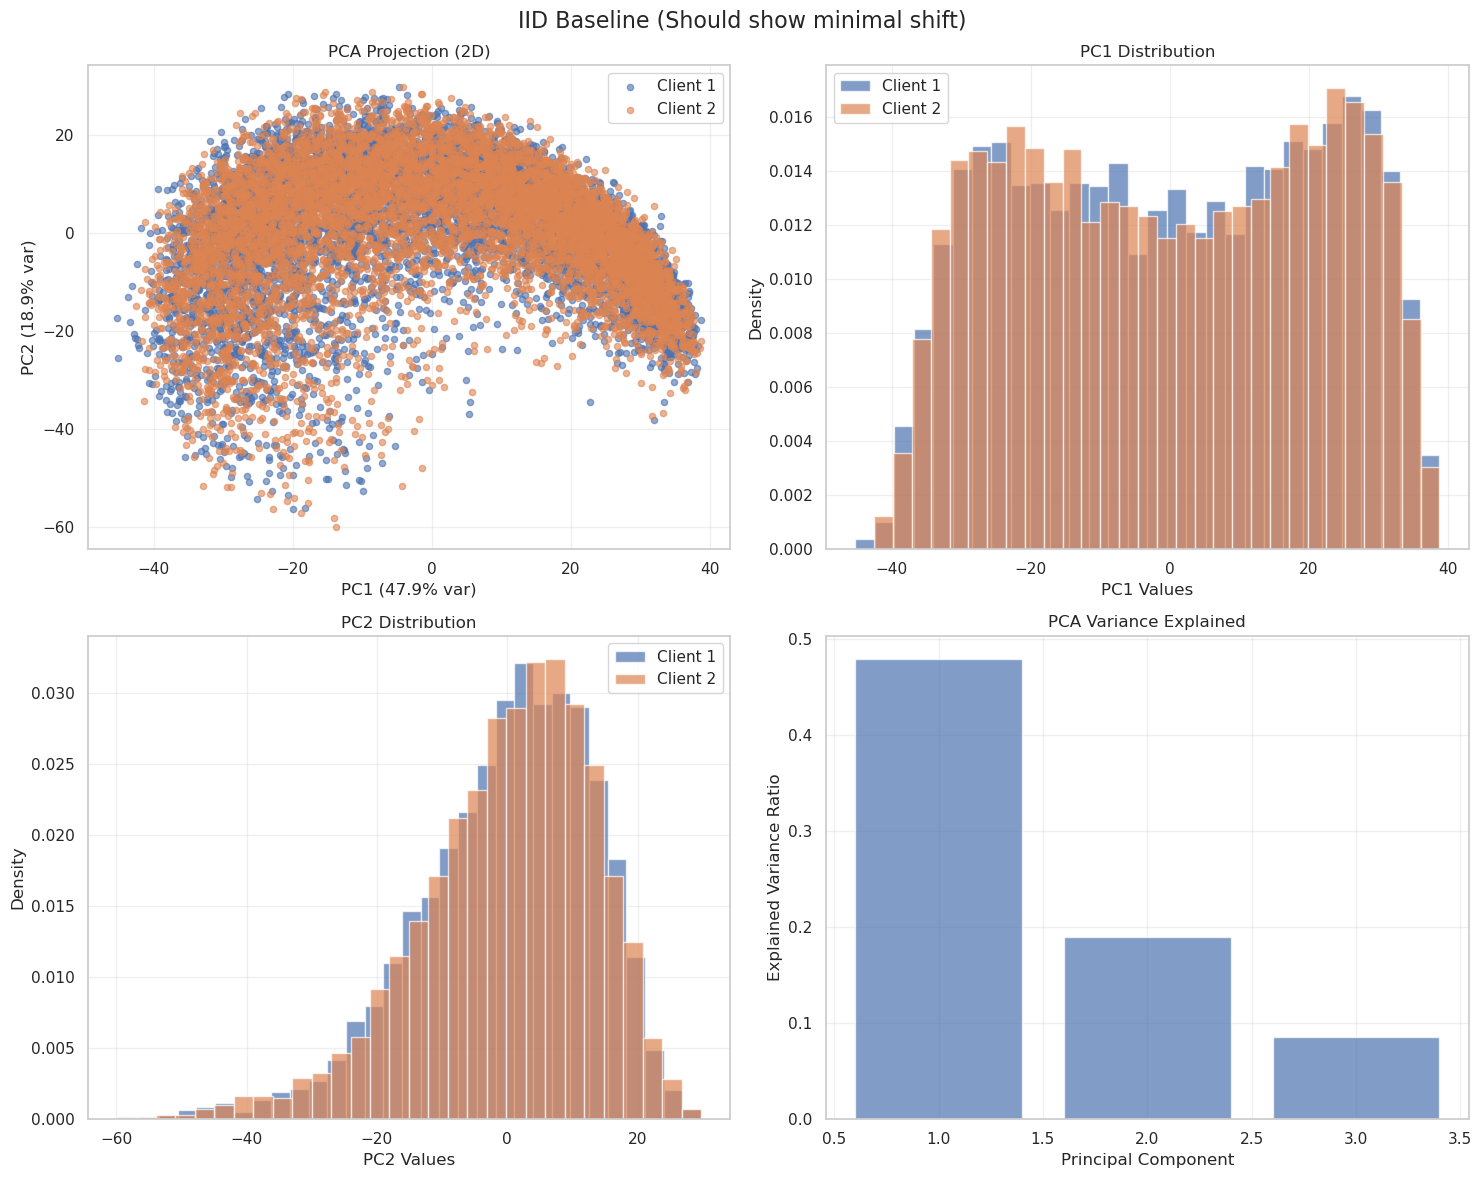


Embedding Analysis Summary:
Client 1: 7201 samples, 960 dimensions
Client 2: 7202 samples, 960 dimensions
Total variance explained by first 3 PCs: 75.4%
Computing feature shift metrics for embeddings:
  Client 1 embeddings: (7201, 960)
  Client 2 embeddings: (7202, 960)
Computing feature shift metrics for raw ECG:
  Client 1 raw ECG: (7201, 1000, 12)
  Client 2 raw ECG: (7202, 1000, 12)

Feature Shift Metrics:
  embedding_mean_l2_distance: 0.143
  embedding_mean_cosine_similarity: 1.000
  embedding_std_l2_distance: 0.084
  embedding_mmd_rbf: 0.001
  embedding_energy_distance: 0.525
  embedding_ks_mean_p_value: 0.5637
  embedding_ks_min_p_value: 0.0794
  embedding_variance_ratio: 0.992
  raw_ecg_mean_ks_p_value: 0.8971
  raw_ecg_std_ks_p_value: 0.6392
  raw_ecg_mean_difference: 0.000
  raw_ecg_std_difference: 0.001


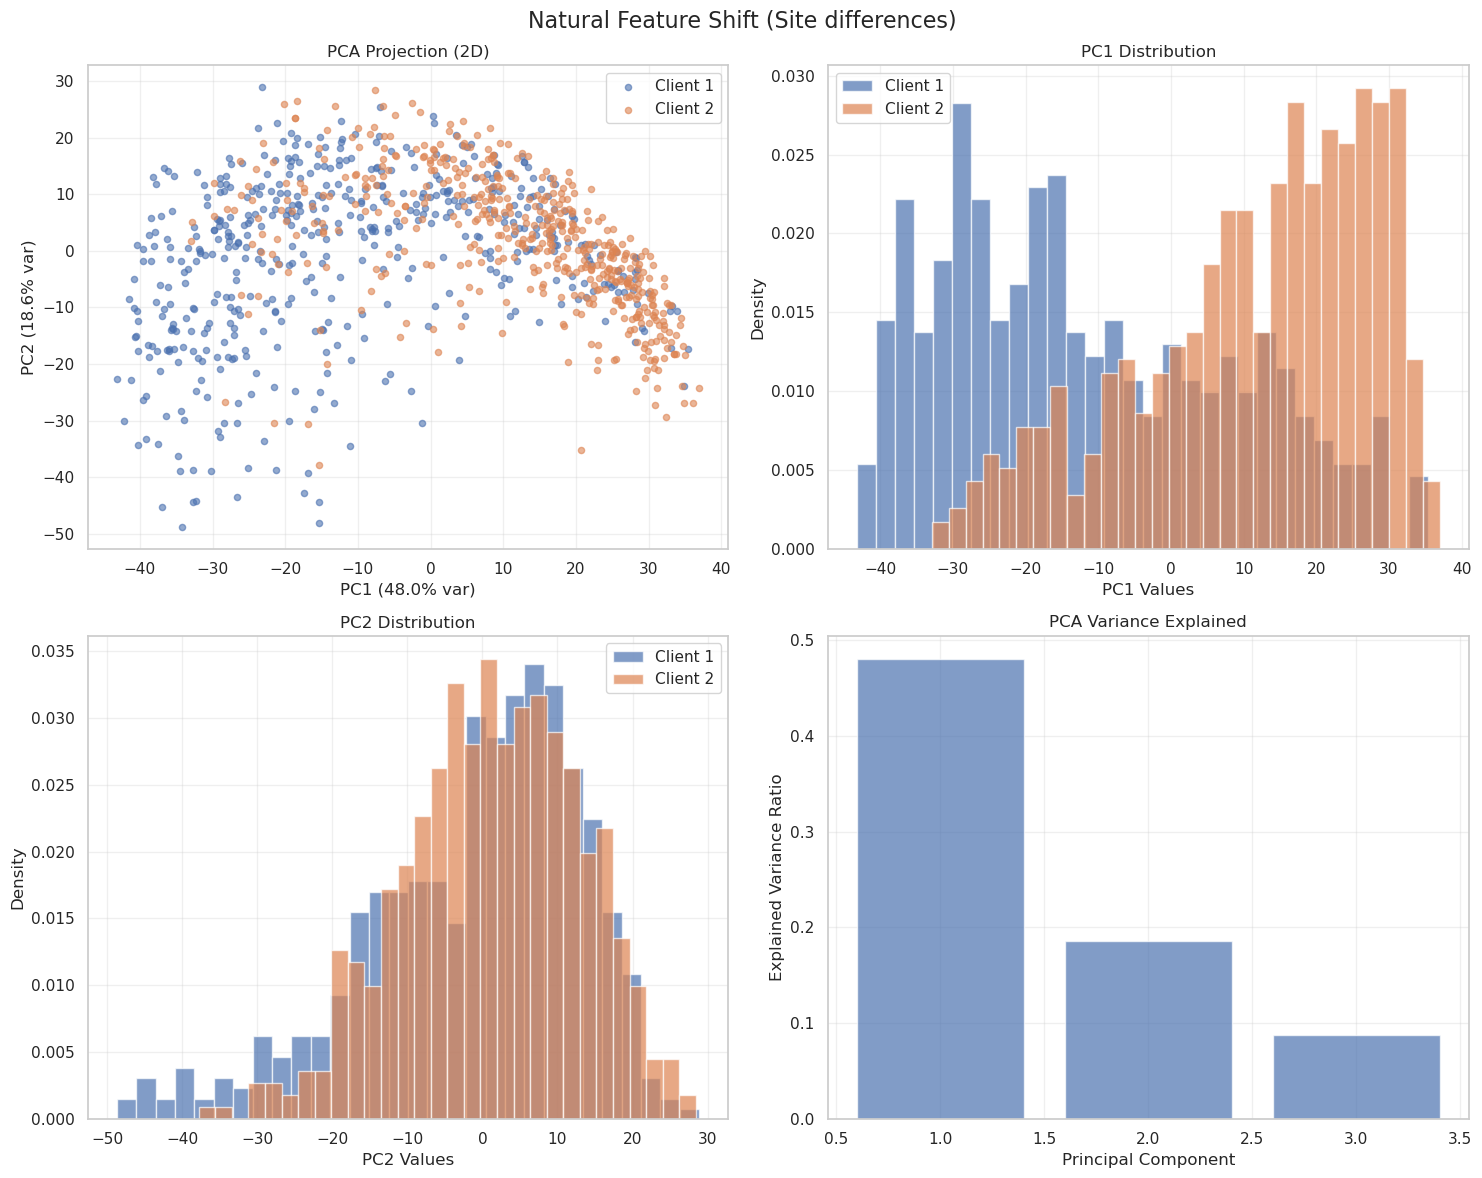


Embedding Analysis Summary:
Client 1: 500 samples, 960 dimensions
Client 2: 500 samples, 960 dimensions
Total variance explained by first 3 PCs: 75.4%
Computing feature shift metrics for embeddings:
  Client 1 embeddings: (500, 960)
  Client 2 embeddings: (500, 960)
Computing feature shift metrics for raw ECG:
  Client 1 raw ECG: (500, 1000, 12)
  Client 2 raw ECG: (500, 1000, 12)

Feature Shift Metrics:
  embedding_mean_l2_distance: 9.489
  embedding_mean_cosine_similarity: 0.931
  embedding_std_l2_distance: 2.799
  embedding_mmd_rbf: 0.148
  embedding_energy_distance: 5.723
  embedding_ks_mean_p_value: 0.0103
  embedding_ks_min_p_value: 0.0000
  embedding_variance_ratio: 1.422
  raw_ecg_mean_ks_p_value: 0.0000
  raw_ecg_std_ks_p_value: 0.0000
  raw_ecg_mean_difference: 0.001
  raw_ecg_std_difference: 0.026


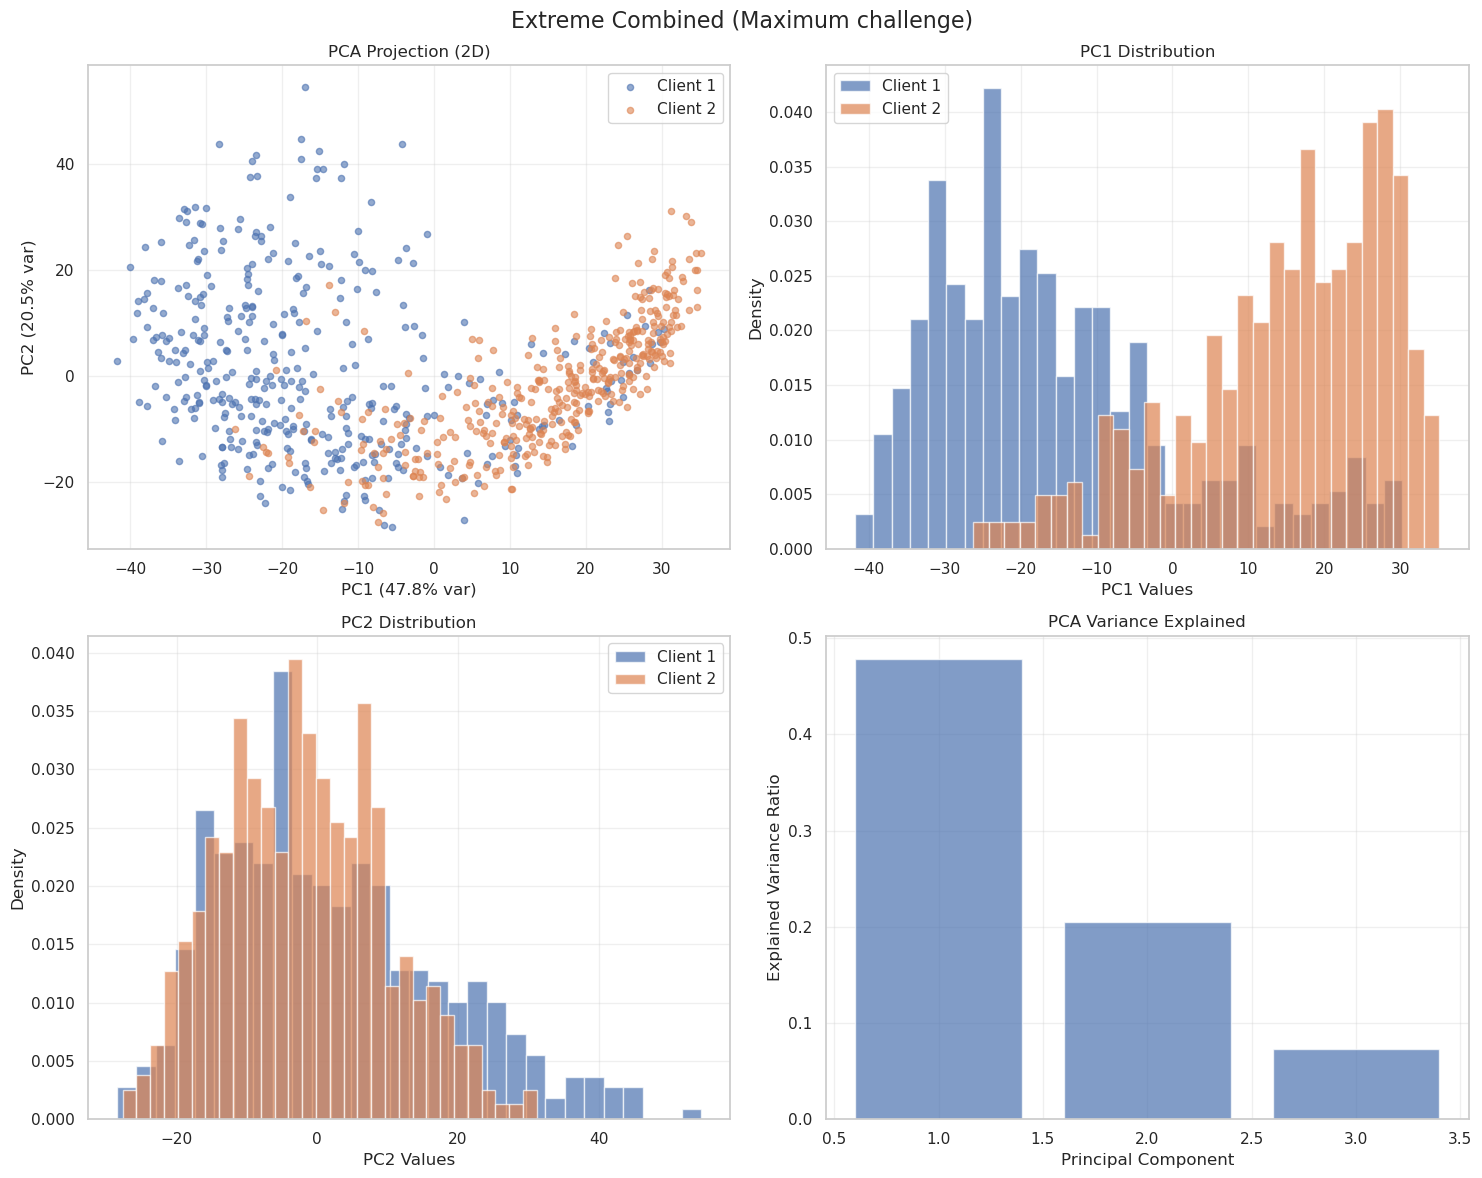


Embedding Analysis Summary:
Client 1: 395 samples, 960 dimensions
Client 2: 400 samples, 960 dimensions
Total variance explained by first 3 PCs: 75.6%
Computing feature shift metrics for embeddings:
  Client 1 embeddings: (395, 960)
  Client 2 embeddings: (400, 960)
Computing feature shift metrics for raw ECG:
  Client 1 raw ECG: (395, 1000, 12)
  Client 2 raw ECG: (400, 1000, 12)

Feature Shift Metrics:
  embedding_mean_l2_distance: 13.140
  embedding_mean_cosine_similarity: 0.867
  embedding_std_l2_distance: 3.509
  embedding_mmd_rbf: 0.263
  embedding_energy_distance: 13.426
  embedding_ks_mean_p_value: 0.0176
  embedding_ks_min_p_value: 0.0000
  embedding_variance_ratio: 1.612
  raw_ecg_mean_ks_p_value: 0.0000
  raw_ecg_std_ks_p_value: 0.0000
  raw_ecg_mean_difference: 0.000
  raw_ecg_std_difference: 0.038

💡 KEY INSIGHTS FOR FEDERATED LEARNING
📊 Federated Learning Challenge Ranking (Easy → Hard):
   1. 🟢 IID_Baseline: 0.001
   2. 🟡 Mild_Label_Skew: 0.086
   3. 🟠 Severe_Label_Skew

In [52]:
# ========================================================================
# COMPREHENSIVE FEDERATED LEARNING DATA ANALYSIS
# Includes both label distribution and feature shift analysis
# ========================================================================

import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

def comprehensive_federated_analysis(Y_with_diagnostics, X_raw_final=None, X_emb_final=None):
    """
    Run comprehensive federated learning analysis including feature shifts.
    
    Args:
        Y_with_diagnostics: Your label/metadata DataFrame
        X_raw_final: Raw ECG data as numpy array (shape=(N, 1000, 12)) (optional)
        X_emb_final: ECG embeddings as numpy array (shape=(N, 960)) (recommended)
    
    Returns:
        Dict containing all results and analysis
    """
    
    print("🔬 COMPREHENSIVE FEDERATED LEARNING ANALYSIS")
    print("=" * 60)
    
    # Initialize enhanced splitter
    splitter = FederatedDataSplitter(Y_with_diagnostics, X_raw_final, X_emb_final)
    
    # Store all results
    all_splits = {}
    all_metrics = {}
    
    # =====================================================================
    # LEVEL 0: IID BASELINE (Control Experiment)
    # =====================================================================
    print("\n🎯 Level 0: IID Baseline (Perfect Federated Learning Scenario)")
    c1_y, c2_y, c1_feat, c2_feat = splitter.level_0_iid_baseline()
    all_splits['IID_Baseline'] = (c1_y, c2_y, c1_feat, c2_feat)
    
    # =====================================================================
    # LEVEL 1: MILD LABEL SKEW (Slightly Realistic)
    # =====================================================================
    print("\n📊 Level 1: Mild Label Skew (α=1.0)")
    c1_y, c2_y, c1_feat, c2_feat = splitter.level_1_mild_label_skew(alpha=5.0)
    all_splits['Mild_Label_Skew'] = (c1_y, c2_y, c1_feat, c2_feat)
    
    # =====================================================================
    # LEVEL 2: SEVERE LABEL SKEW (Challenging)
    # =====================================================================
    print("\n⚠️  Level 2: Severe Label Skew (α=0.1)")
    c1_y, c2_y, c1_feat, c2_feat = splitter.level_2_severe_label_skew(alpha=0.5)
    all_splits['Severe_Label_Skew'] = (c1_y, c2_y, c1_feat, c2_feat)
    
    # =====================================================================
    # LEVEL 3: NATURAL FEATURE SHIFT (Real-world Site Differences)
    # =====================================================================
    print("\n🏥 Level 3: Natural Feature Shift (Different Hospitals)")
    c1_y, c2_y, c1_feat, c2_feat = splitter.level_3_natural_feature_shift(target_size=500)
    all_splits['Natural_Feature_Shift'] = (c1_y, c2_y, c1_feat, c2_feat)
    
    # =====================================================================
    # LEVEL 4: EXTREME COMBINED (Worst Case Scenario)
    # =====================================================================
    print("\n💥 Level 4: Extreme Combined Non-IID")
    c1_y, c2_y, c1_feat, c2_feat = splitter.level_4_extreme_combined_non_iid(
        client_1_target_dist={'NORM': 0.05, 'other': 0.95},  # Heart attack specialist
        client_2_target_dist={'NORM': 0.95, 'other': 0.05},           # Screening center
        target_size=400
    )
    all_splits['Extreme_Combined'] = (c1_y, c2_y, c1_feat, c2_feat)
    
    # =====================================================================
    # LEVEL 5: SITE + TEMPORAL (Hospital + Era Differences)
    # =====================================================================
    print("\n⏰ Level 5: Site + Temporal Split")
    try:
        c1_y, c2_y, c1_feat, c2_feat = splitter.level_5_site_temporal_split(
            client_1_site=0, client_2_site=1,
            client_1_date_range=('1995-01-01', None),  
            client_2_date_range=(None, '1993-01-01'),   
            target_size=400
        )
        all_splits['Site_Temporal'] = (c1_y, c2_y, c1_feat, c2_feat)
    except Exception as e:
        print(f"⚠️  Level 5 failed: {e}")
    
    # =====================================================================
    # COMPREHENSIVE METRICS COMPARISON
    # =====================================================================
    print("\n📈 COMPUTING COMPREHENSIVE NON-IID METRICS")
    print("=" * 50)
    
    # Compute metrics for each split
    for split_name, split_data in all_splits.items():
        c1_y, c2_y, c1_feat, c2_feat = split_data
        metrics = splitter.compute_non_iid_metrics(c1_y, c2_y, c1_feat, c2_feat)
        all_metrics[split_name] = metrics
    
    # Create comprehensive comparison
    comparison_df = splitter.compare_all_splits(all_splits)
    
    # =====================================================================
    # FEATURE SHIFT VISUALIZATIONS (if embeddings available)
    # =====================================================================
    if X_emb_final is not None:
        print("\n🎨 GENERATING FEATURE SHIFT VISUALIZATIONS")
        print("=" * 50)
        
        # Show most interesting cases
        interesting_splits = [
            ('IID_Baseline', 'IID Baseline (Should show minimal shift)'),
            ('Natural_Feature_Shift', 'Natural Feature Shift (Site differences)'),
            ('Extreme_Combined', 'Extreme Combined (Maximum challenge)')
        ]
        
        for split_key, title in interesting_splits:
            if split_key in all_splits:
                _, _, c1_feat, c2_feat = all_splits[split_key]
                splitter.visualize_embedding_shift(c1_feat, c2_feat, title)
    
    # =====================================================================
    # SUMMARY INSIGHTS
    # =====================================================================
    print("\n💡 KEY INSIGHTS FOR FEDERATED LEARNING")
    print("=" * 50)
    
    # Rank splits by difficulty (higher = more challenging for FL)
    if len(comparison_df) > 0:
        # Create difficulty score
        difficulty_metrics = []
        
        if 'label_js_divergence' in comparison_df.columns:
            difficulty_metrics.append('label_js_divergence')
        if 'embedding_mean_l2_distance' in comparison_df.columns:
            difficulty_metrics.append('embedding_mean_l2_distance')
        if 'embedding_mmd_rbf' in comparison_df.columns:
            difficulty_metrics.append('embedding_mmd_rbf')
        
        if difficulty_metrics:
            # Normalize and combine metrics
            difficulty_df = comparison_df[difficulty_metrics].copy()
            for col in difficulty_df.columns:
                difficulty_df[col] = (difficulty_df[col] - difficulty_df[col].min()) / (difficulty_df[col].max() - difficulty_df[col].min())
            
            difficulty_df['overall_difficulty'] = difficulty_df.mean(axis=1)
            difficulty_ranking = difficulty_df.sort_values('overall_difficulty')
            
            print("📊 Federated Learning Challenge Ranking (Easy → Hard):")
            for i, (split_name, difficulty) in enumerate(difficulty_ranking['overall_difficulty'].items()):
                emoji = ["🟢", "🟡", "🟠", "🔴", "💀"][min(i, 4)]
                print(f"   {i+1}. {emoji} {split_name}: {difficulty:.3f}")
    
    # Feature shift summary
    if X_emb_final is not None and len(comparison_df) > 0:
        if 'embedding_mean_cosine_similarity' in comparison_df.columns:
            print(f"\n🔍 Feature Similarity Analysis:")
            cos_sim = comparison_df['embedding_mean_cosine_similarity']
            most_similar = cos_sim.idxmax()
            least_similar = cos_sim.idxmin()
            print(f"   Most similar embeddings: {most_similar} ({cos_sim[most_similar]:.3f})")
            print(f"   Least similar embeddings: {least_similar} ({cos_sim[least_similar]:.3f})")
    
    # Recommendations
    print(f"\n🎯 FEDERATED LEARNING RECOMMENDATIONS:")
    print(f"   • Start testing with: IID Baseline (control)")
    print(f"   • Progress through: Mild → Severe → Natural → Extreme")
    print(f"   • Focus on algorithms that handle both label and feature shifts")
    print(f"   • Consider domain adaptation techniques for site differences")
    if 'Site_Temporal' in all_splits:
        print(f"   • Test temporal robustness with Site + Temporal split")
    
    return {
        'splitter': splitter,
        'splits': all_splits,
        'metrics': all_metrics,
        'comparison_df': comparison_df,
        'difficulty_ranking': difficulty_ranking if 'difficulty_ranking' in locals() else None
    }

# ========================================================================
# DETAILED FEATURE ANALYSIS FUNCTIONS
# ========================================================================

def detailed_embedding_analysis(c1_features, c2_features, split_name=""):
    """
    Perform detailed analysis of embedding differences between clients.
    """
    if 'X_emb' not in c1_features or 'X_emb' not in c2_features:
        print("No embeddings available for detailed analysis")
        return
    
    c1_emb = c1_features['X_emb']  # Already numpy array
    c2_emb = c2_features['X_emb']  # Already numpy array
    
    # Handle different shapes
    if len(c1_emb.shape) > 2:
        c1_emb = c1_emb.reshape(c1_emb.shape[0], -1)
        c2_emb = c2_emb.reshape(c2_emb.shape[0], -1)
    
    print(f"\n🔬 DETAILED EMBEDDING ANALYSIS: {split_name}")
    print("=" * 50)
    
    # Basic statistics
    print(f"📊 Basic Statistics:")
    print(f"   Client 1: {c1_emb.shape[0]} samples × {c1_emb.shape[1]} dimensions")
    print(f"   Client 2: {c2_emb.shape[0]} samples × {c2_emb.shape[1]} dimensions")
    
    # Statistical moments
    c1_mean, c1_std = np.mean(c1_emb, axis=0), np.std(c1_emb, axis=0)
    c2_mean, c2_std = np.mean(c2_emb, axis=0), np.std(c2_emb, axis=0)
    
    print(f"\n📈 Distribution Characteristics:")
    print(f"   Mean difference (L2): {np.linalg.norm(c1_mean - c2_mean):.3f}")
    print(f"   Std difference (L2): {np.linalg.norm(c1_std - c2_std):.3f}")
    print(f"   Client 1 mean magnitude: {np.linalg.norm(c1_mean):.3f}")
    print(f"   Client 2 mean magnitude: {np.linalg.norm(c2_mean):.3f}")
    
    # Dimension analysis
    mean_diffs = np.abs(c1_mean - c2_mean)
    top_diff_dims = np.argsort(mean_diffs)[-10:][::-1]
    
    print(f"\n🎯 Top 10 Most Different Dimensions:")
    for i, dim in enumerate(top_diff_dims):
        print(f"   {i+1}. Dim {dim}: |{c1_mean[dim]:.3f} - {c2_mean[dim]:.3f}| = {mean_diffs[dim]:.3f}")
    
    return {
        'mean_diff_l2': np.linalg.norm(c1_mean - c2_mean),
        'std_diff_l2': np.linalg.norm(c1_std - c2_std),
        'top_different_dims': top_diff_dims,
        'dimension_differences': mean_diffs
    }

# ========================================================================
# USAGE EXAMPLES WITH YOUR ECG DATA
# ========================================================================

# Example 1: Basic usage (Y data only) - minimal analysis
# results = comprehensive_federated_analysis(Y_with_diagnostics)

# Example 2: Full analysis with embeddings (RECOMMENDED for ECG research)
# Your data should be:
# - Y_with_diagnostics: DataFrame with shape (21799, n_features) 
# - X_raw_final: numpy array with shape (21799, 1000, 12) - raw ECG signals
# - X_emb_final: numpy array with shape (21799, 960) - ECG embeddings

results = comprehensive_federated_analysis(
    Y_with_diagnostics=Y_with_diagnostics,
    X_raw_final=X_raw_final,    # Shape: (21799, 1000, 12)
    X_emb_final=X_emb_final     # Shape: (21799, 960) 
)

# Example 3: Generate detailed readiness report
# results = comprehensive_federated_analysis(Y_with_diagnostics, X_raw_final, X_emb_final)
# final_report = federated_learning_readiness_report(results)

# Example 4: Quick testing function
# results = test_with_your_data(
#     df=Y_with_diagnostics, 
#     X_raw=X_raw_final,     # numpy array (21799, 1000, 12)
#     X_emb=X_emb_final,     # numpy array (21799, 960)
#     target_size=500
# )

# Example 5: Detailed analysis of specific split
# results = comprehensive_federated_analysis(Y_with_diagnostics, X_raw_final, X_emb_final)
# if 'Natural_Feature_Shift' in results['splits']:
#     _, _, c1_feat, c2_feat = results['splits']['Natural_Feature_Shift']
#     detailed_embedding_analysis(c1_feat, c2_feat, "Natural Feature Shift")


In [28]:
Y_with_diagnostics

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,filename_lr,filename_hr,diag_AFIB,diag_AFLT,diag_CD,diag_HYP,diag_MI,diag_NORM,diag_PACE,diag_STTC
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,records100/00000/00001_lr,records500/00000/00001_hr,0,0,0,0,0,1,0,0
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,records100/00000/00002_lr,records500/00000/00002_hr,0,0,0,0,0,1,0,0
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,records100/00000/00003_lr,records500/00000/00003_hr,0,0,0,0,0,1,0,0
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,records100/00000/00004_lr,records500/00000/00004_hr,0,0,0,0,0,1,0,0
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,records100/00000/00005_lr,records500/00000/00005_hr,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,records100/21000/21833_lr,records500/21000/21833_hr,0,0,0,0,0,0,0,1
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,records100/21000/21834_lr,records500/21000/21834_hr,0,0,0,0,0,1,0,0
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,records100/21000/21835_lr,records500/21000/21835_hr,0,0,0,0,0,0,0,1


KeyboardInterrupt: 

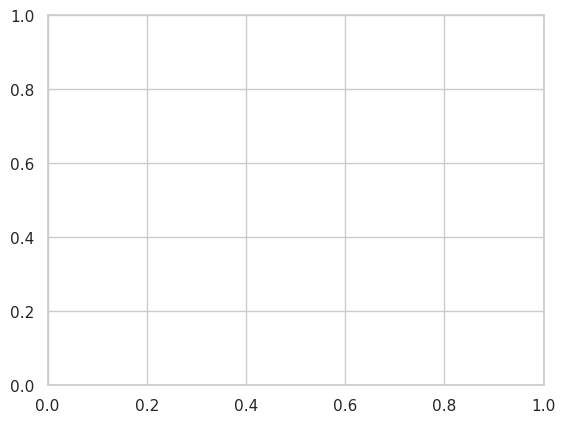

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
sns.kdeplot(cosine_similarity(X['emb']))

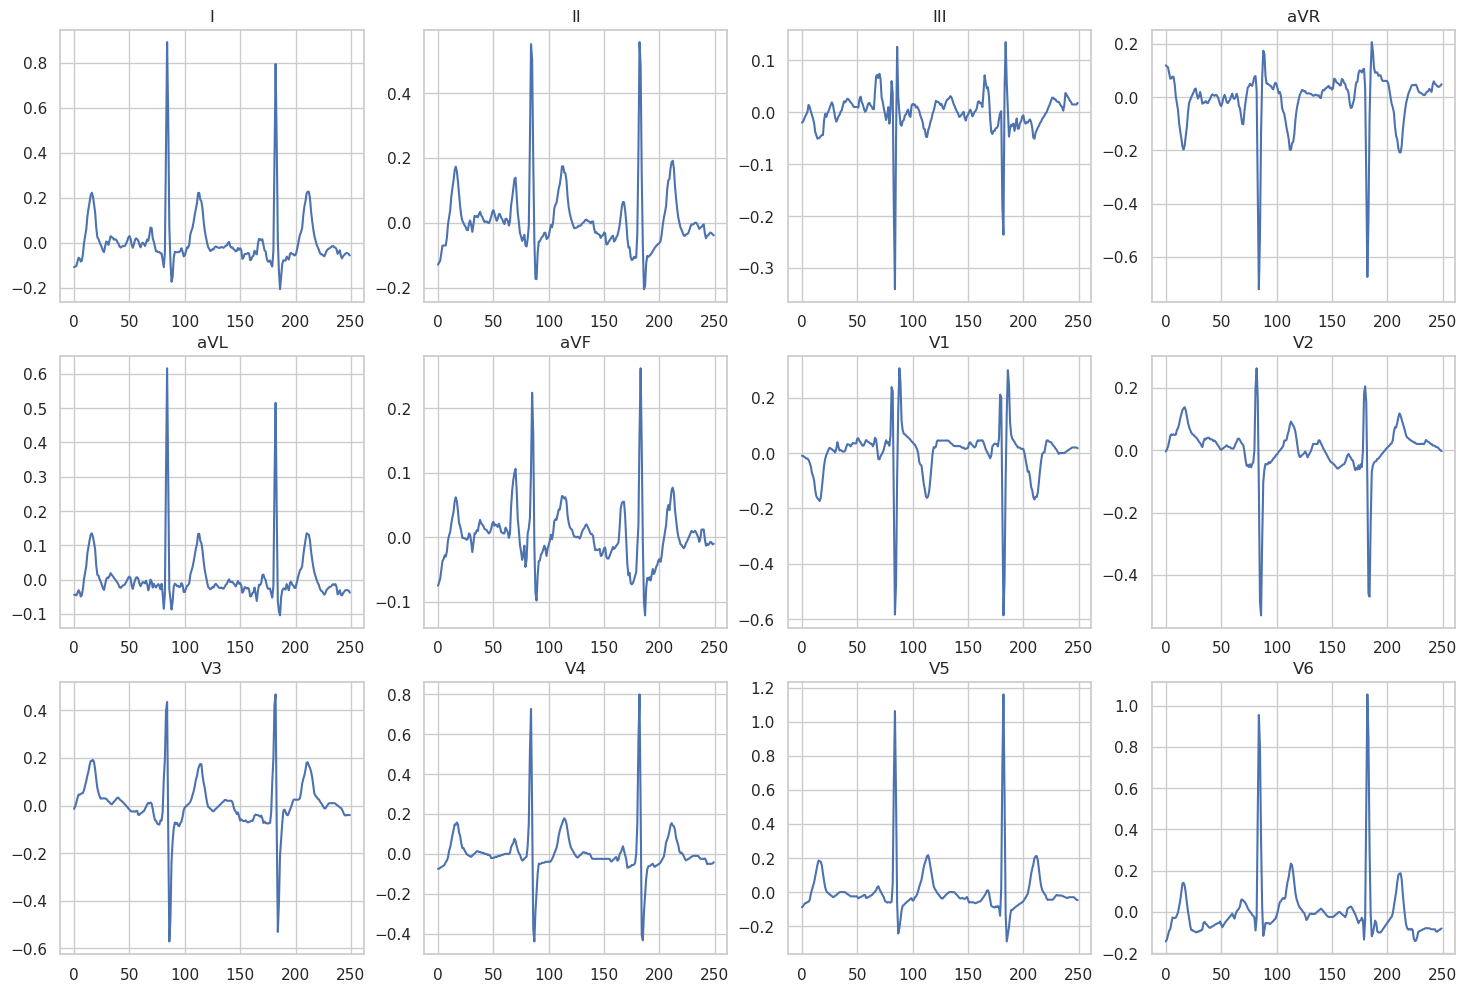

In [559]:
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration
leads = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
# Plot each dimension
for i in range(12):
    axes[i].plot(X[19031,:250,i])
    axes[i].set_title(leads[i])

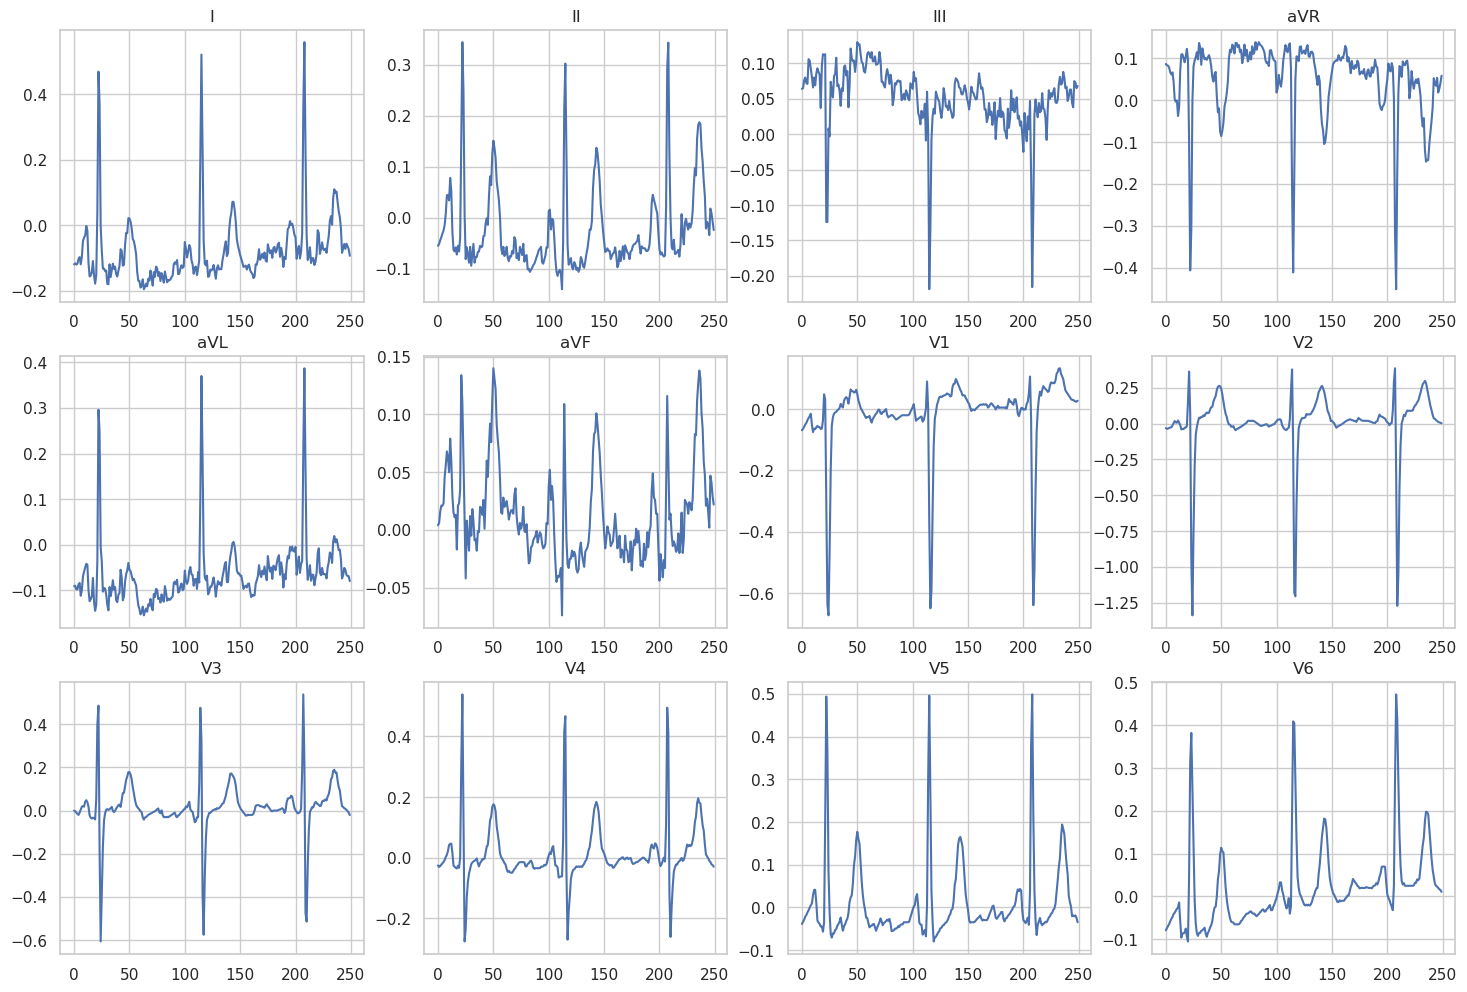

In [560]:
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration
leads = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
# Plot each dimension
for i in range(12):
    axes[i].plot(X[0,:250,i])
    axes[i].set_title(leads[i])

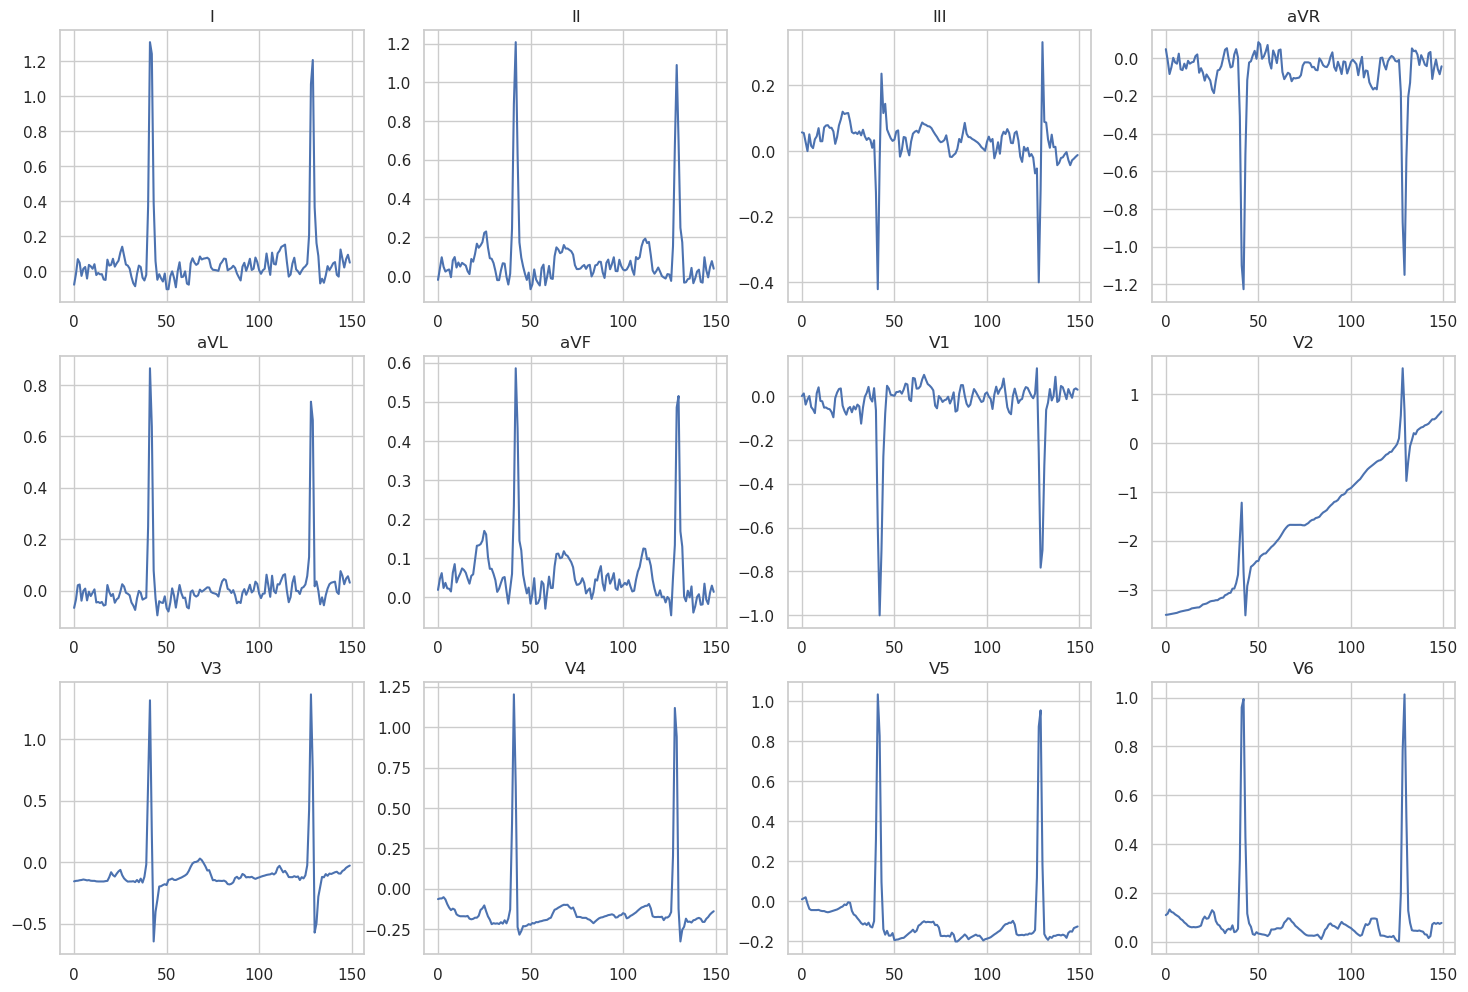

In [363]:
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration
leads = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
# Plot each dimension
for i in range(12):
    axes[i].plot(X[-3,:150,i])
    axes[i].set_title(leads[i])

# Data v2

In [318]:
from lib.ecg_gen.template_creation.generators import *
from lib.ecg_gen.template_creation.utils import *

beat = generate_pvc_template(seed =1, origin = 'rv_origin')
metadata = create_base_metadata(
    label="old_mi",
    variant="inferior",
    seed=42,
    description="Inferior old-MI with deep Q in II/III/aVF",
    validation_data=validate_and_get_delineation(beat, "old_mi")
)

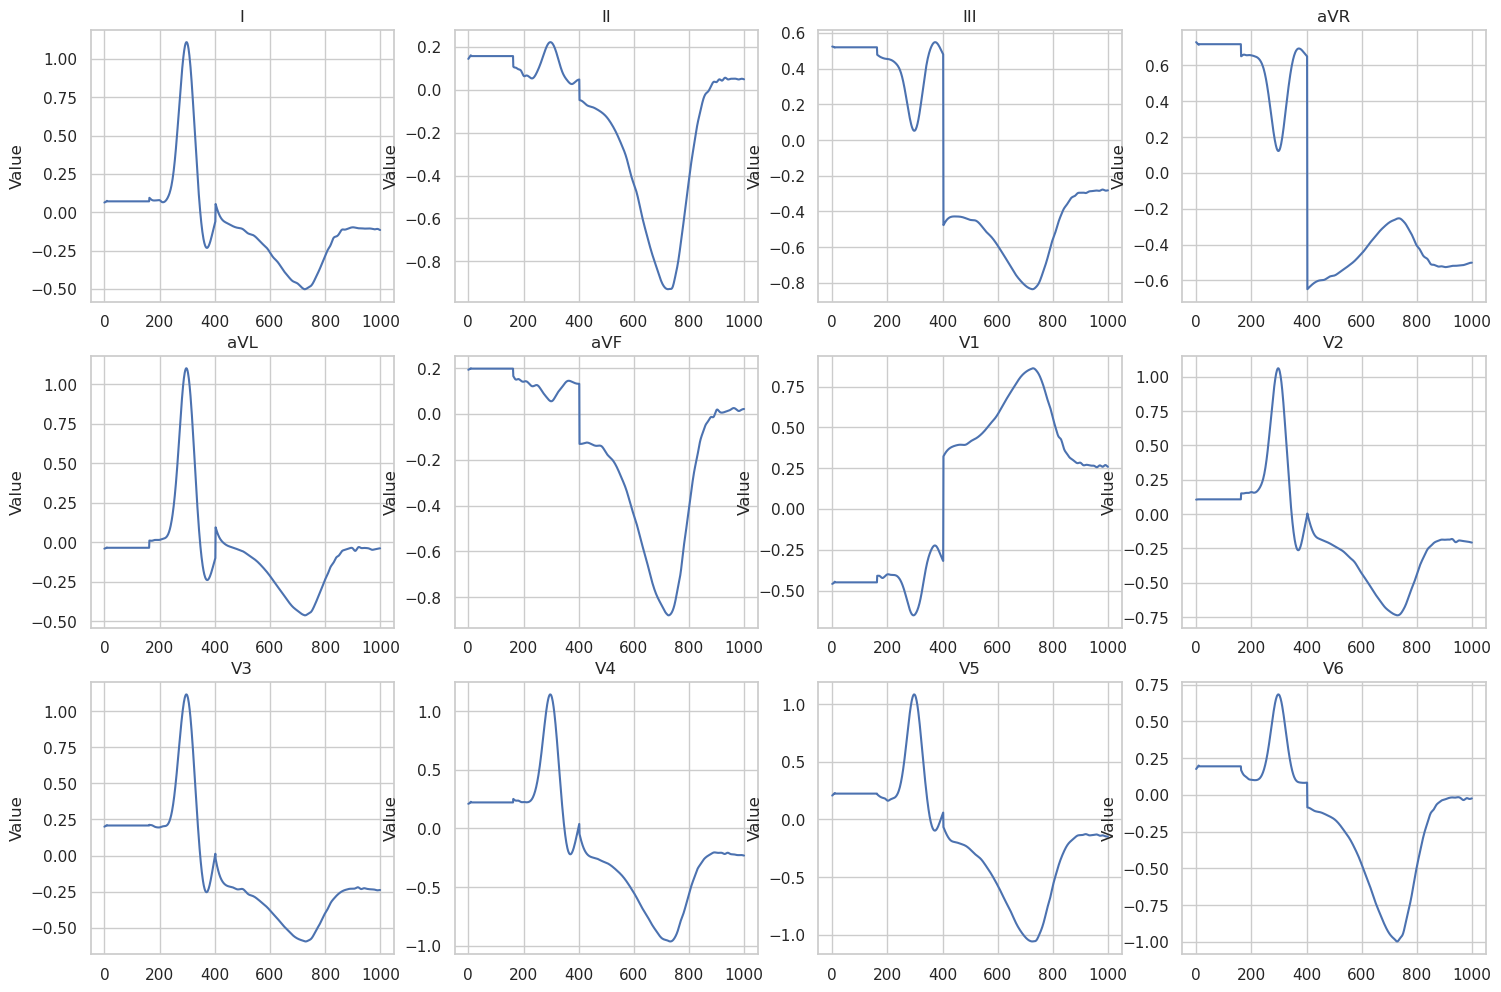

In [319]:
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration
leads = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
# Plot each dimension
for i in range(12):
    axes[i].plot(beat[i])
    axes[i].set_title(leads[i])
    axes[i].set_ylabel('Value')

# Data v1

In [477]:
costs = [100.0, 10.0, 5.0, 1.0, 0.5, 0.1]
clients = [0,1]
meta = {}
data = {}
timesteps = {}
for cost in costs:
    meta[cost] = {}
    data[cost] = {}
    timesteps[cost] = {}
    for client in clients:
        df =pd.read_csv(f'{DATA_DIR}/ecg_clinical_{cost}/client_{client}_metadata.csv')
        meta[cost][client] = df[df['split'] == 'train']
        meta[cost][client].reset_index(drop =True, inplace=True)
        data[cost][client] = torch.load(f"{DATA_DIR}/ecg_clinical_{cost}/client_{client}_train.pt", weights_only=True)
        data[cost][client] = data[cost][client].numpy()
        timesteps[cost][client] = torch.load(f"{DATA_DIR}/ecg_clinical_{cost}/client_{client}_time_steps_train.pt", weights_only=True)
        timesteps[cost][client] = timesteps[cost][client].numpy()

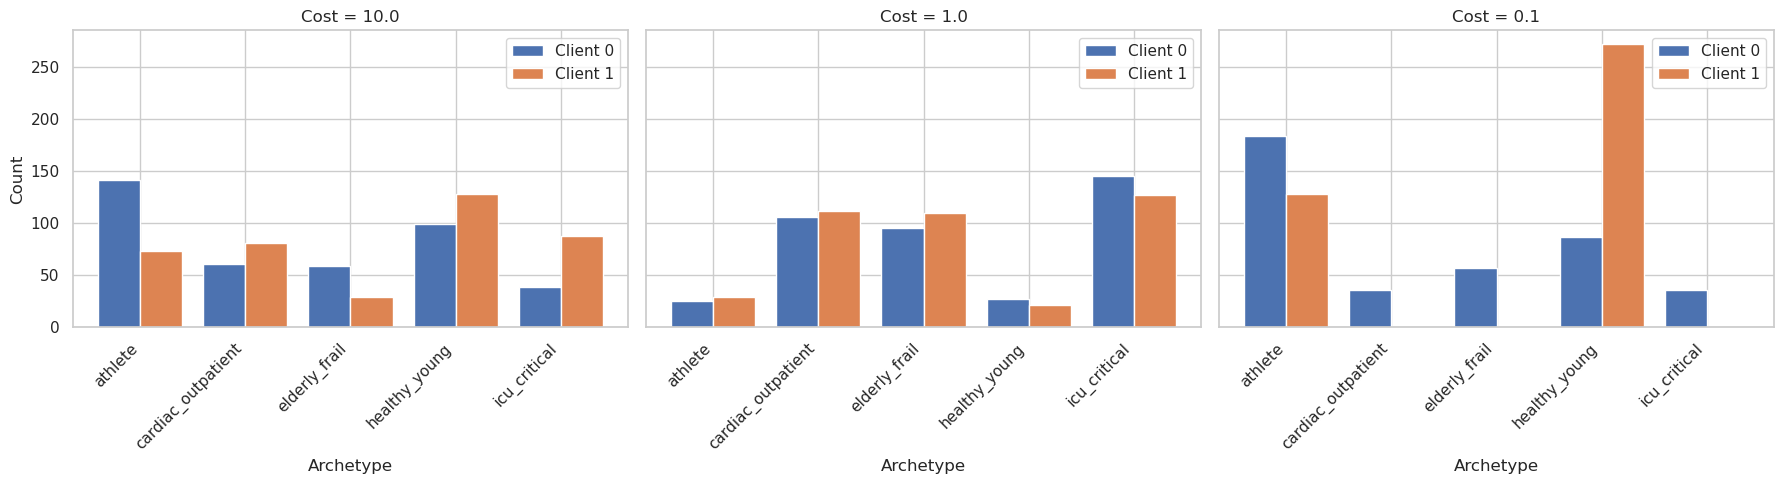

In [478]:
# Check archetype distribution across clients and costs
records = []
costs = [10.0,  1.0, 0.1]
for cost in costs:
    # value-counts for each client’s archetypes
    vc0 = meta[cost][0]["archetype"].value_counts()
    vc1 = meta[cost][1]["archetype"].value_counts()
    
    # union of archetypes seen in either client
    all_arches = set(vc0.index).union(vc1.index)
    
    for arch in all_arches:
        records.append(
            {
                "cost": cost,
                "archetype": arch,
                "client_0_count": vc0.get(arch, 0),
                "client_1_count": vc1.get(arch, 0),
            }
        )

archetype_df = pd.DataFrame(records).sort_values(["cost", "archetype"]).reset_index(drop=True)
unique_costs = sorted(archetype_df["cost"].unique(), reverse=True)
fig, axs = plt.subplots(1, len(unique_costs), figsize=(18, 5), sharey=True)

for i, cost in enumerate(unique_costs):
    subset = archetype_df[archetype_df["cost"] == cost]
    x = range(len(subset))
    axs[i].bar(x, subset["client_0_count"], width=0.4, label="Client 0", align="center")
    axs[i].bar([xi + 0.4 for xi in x], subset["client_1_count"], width=0.4, label="Client 1", align="center")
    axs[i].set_xticks([xi + 0.2 for xi in x])
    axs[i].set_xticklabels(subset["archetype"], rotation=45, ha='right')
    axs[i].set_title(f"Cost = {cost}")
    axs[i].set_xlabel("Archetype")
    if i == 0:
        axs[i].set_ylabel("Count")
    axs[i].legend()

fig.tight_layout()
plt.show()

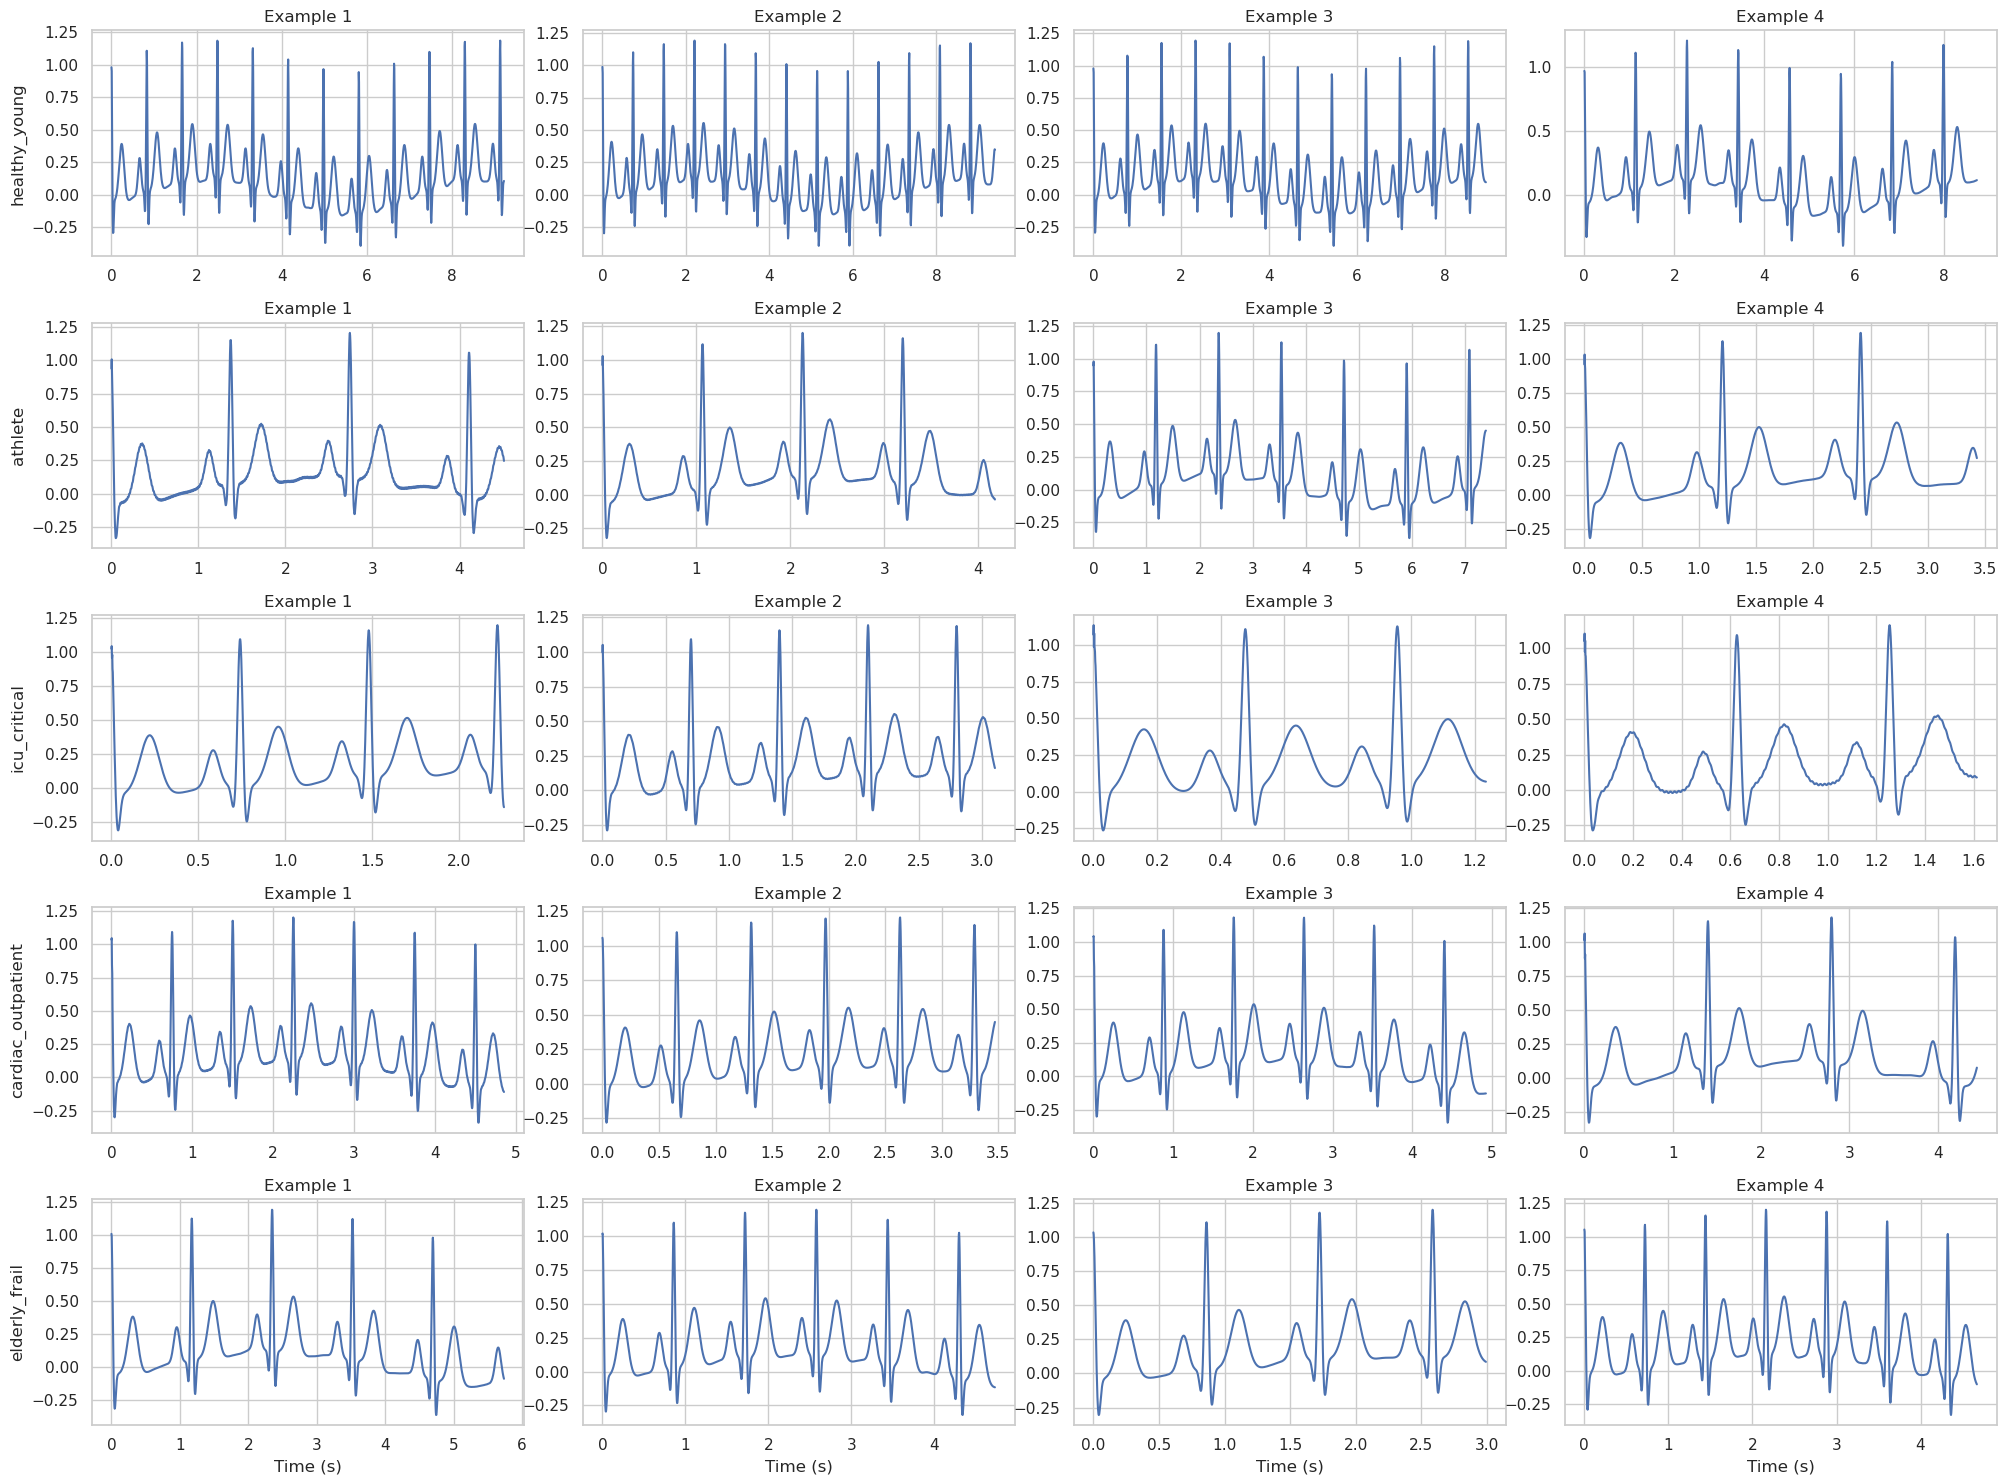

In [470]:
cost = 10.0
client = 0
# Get metadata, data, and timesteps
meta_df = meta[cost][client]
signals = data[cost][client]
times = timesteps[cost][client]

# Identify unique archetypes
unique_archetypes = meta_df["archetype"].unique()

# Set up subplots: one row per archetype, 4 columns
fig, axs = plt.subplots(len(unique_archetypes), 4, figsize=(20, 3 * len(unique_archetypes)), sharex=False)


for row_idx, arch in enumerate(unique_archetypes):
    # Get all indices for this archetype

    arch_indices = meta_df[meta_df["archetype"] == arch].index[:4]  # Take up to 4 examples

    for col_idx in range(4):
        ax = axs[row_idx][col_idx] if len(unique_archetypes) > 1 else axs[0][col_idx]
        
        if col_idx < len(arch_indices):
            idx = arch_indices[col_idx]
            time_idx = signals.shape[1] // 100
            plot_data = np.reshape(signals[idx, :time_idx], (-1,))
            plot_time = np.reshape(times[idx, :time_idx], (-1,))
            ax.plot(plot_time, plot_data)
            ax.set_title(f"Example {col_idx + 1}")
        else:
            ax.axis("off")  # Hide unused subplot

        if col_idx == 0:
            ax.set_ylabel(f"{arch}")

# Label bottom x-axis
for col in range(4):
    axs[-1][col].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()


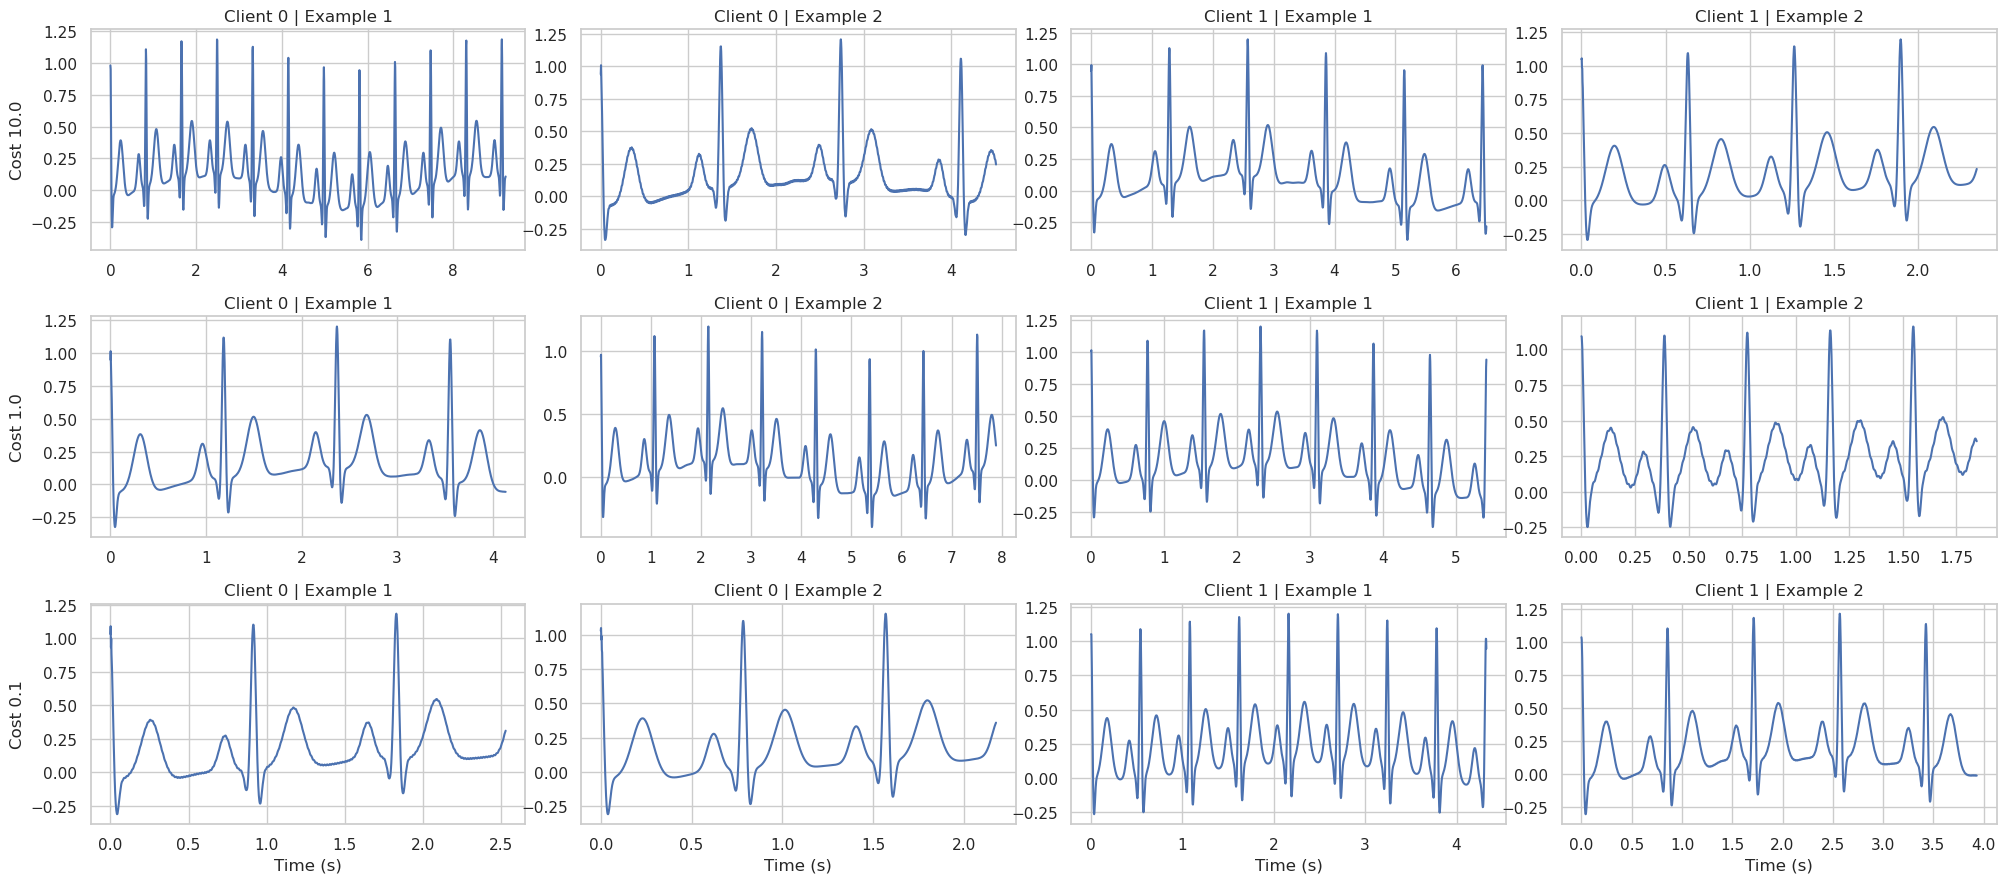

In [471]:
# Define number of examples per client
num_examples_per_client = 2

# Set up subplots: one row per cost, 4 columns
fig, axs = plt.subplots(len(costs), 4, figsize=(20, 3 * len(costs)), sharex=False)

# Ensure axs is always 2D
if len(costs) == 1:
    axs = [axs]

for row_idx, cost in enumerate(costs):
    for client in clients:
        meta_df = meta[cost][client]
        signals = data[cost][client]
        times = timesteps[cost][client]

        # Randomly sample indices
        available_indices = list(meta_df.index)
        sampled_indices = random.sample(available_indices, min(num_examples_per_client, len(available_indices)))
        sampled_indices = [0,1]
        for i, idx in enumerate(sampled_indices):
            col_idx = client * num_examples_per_client + i  # 0 or 1 for client 0, 2 or 3 for client 1
            time_idx = signals.shape[1] // 100  # Truncate
            plot_data = np.reshape(signals[idx, :time_idx], (-1,))
            plot_time = np.reshape(times[idx, :time_idx], (-1,))

            ax = axs[row_idx][col_idx]
            ax.plot(plot_time, plot_data)
            ax.set_title(f"Client {client} | Example {i + 1}")

            if col_idx == 0:
                ax.set_ylabel(f"Cost {cost}")

# Label bottom x-axis
for col in range(4):
    axs[-1][col].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()


In [474]:
meta[0.1][1]

,client_id,patient_id,archetype,geography,medication,comorbidity,parameter_comorbidity,timing_comorbidity,morphology_comorbidity,sampling_rate,...,motion_artifact_prob,powerline_frequency_hz,adc_resolution_bits,events_detected,total_events,event_types,split,original_length,padded_length,padding_applied
0,1,115,elderly_frail,north_america,['diuretic'],"['copd', 'old_anterior_mi']",['copd'],[],[],358,...,0.10,60,12,{},0,[],train,42978,155043,True
1,1,135,cardiac_outpatient,north_america,['beta_blocker'],"['diabetes', 'heart_failure', 'mobitz_I_wencke...","['diabetes', 'heart_failure']",[],[],394,...,0.12,60,14,{},0,[],train,47264,155043,True
2,1,191,elderly_frail,north_america,['beta_blocker'],"['diabetes', 'copd', 'left_bundle_branch_block']","['diabetes', 'copd']",[],[],259,...,0.10,60,14,{},0,[],train,31122,155043,True
3,1,435,healthy_young,north_america,[],[],[],[],[],206,...,0.05,60,10,{},0,[],train,24675,155043,True
4,1,42,cardiac_outpatient,north_america,['beta_blocker'],"['diabetes', 'heart_failure', 'pvc_burden_mode...","['diabetes', 'heart_failure']",[],[],407,...,0.12,60,15,{},0,[],train,48843,155043,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1,470,elderly_frail,north_america,['beta_blocker'],"['diabetes', 'old_anterior_mi']",['diabetes'],[],[],466,...,0.10,60,13,{},0,[],train,55860,155043,True
396,1,214,cardiac_outpatient,north_america,"['beta_blocker', 'ace_inhibitor']",['heart_failure'],['heart_failure'],[],[],319,...,0.12,60,15,{},0,[],train,38272,155043,True
397,1,31,elderly_frail,north_america,"['beta_blocker', 'ace_inhibitor']","['copd', 'heart_failure']","['copd', 'heart_failure']",[],[],339,...,0.10,60,13,{},0,[],train,40702,155043,True
398,1,398,healthy_young,north_america,[],[],[],[],[],211,...,0.05,60,11,{},0,[],train,25305,155043,True


In [473]:
meta[0.1][0]

,client_id,patient_id,archetype,geography,medication,comorbidity,parameter_comorbidity,timing_comorbidity,morphology_comorbidity,sampling_rate,...,motion_artifact_prob,powerline_frequency_hz,adc_resolution_bits,events_detected,total_events,event_types,split,original_length,padded_length,padding_applied
0,0,432,cardiac_outpatient,north_america,"['beta_blocker', 'antiarrhythmic', 'diuretic']","['heart_failure', 'mobitz_I_wenckebach']",['heart_failure'],[],[],559,...,0.12,60,13,{},0,[],train,67114,141572,True
1,0,131,icu_critical,north_america,"['beta_blocker', 'antiarrhythmic', 'digoxin']","['diabetes', 'copd', 'mobitz_I_wenckebach', 'o...","['diabetes', 'copd']",[],[],650,...,0.08,60,16,{},0,[],train,78012,141572,True
2,0,396,cardiac_outpatient,north_america,"['beta_blocker', 'ace_inhibitor']",['first_degree_av_block'],[],[],[],390,...,0.12,60,13,{},0,[],train,46854,141572,True
3,0,354,cardiac_outpatient,north_america,"['beta_blocker', 'ace_inhibitor']","['diabetes', 'pvc_burden_moderate']",['diabetes'],[],[],432,...,0.12,60,13,{},0,[],train,51831,141572,True
4,0,147,elderly_frail,north_america,['ace_inhibitor'],['diabetes'],['diabetes'],[],[],454,...,0.10,60,12,{},0,[],train,54501,141572,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0,385,elderly_frail,north_america,['beta_blocker'],['diabetes'],['diabetes'],[],[],316,...,0.10,60,13,{},0,[],train,37962,141572,True
396,0,270,cardiac_outpatient,north_america,"['ace_inhibitor', 'diuretic']","['copd', 'pvc_burden_moderate']",['copd'],[],[],466,...,0.12,60,14,{},0,[],train,55926,141572,True
397,0,475,cardiac_outpatient,north_america,"['diuretic', 'digoxin']","['diabetes', 'heart_failure']","['diabetes', 'heart_failure']",[],[],452,...,0.12,60,12,{},0,[],train,54273,141572,True
398,0,150,icu_critical,north_america,['ace_inhibitor'],"['diabetes', 'copd', 'renal_disease']","['diabetes', 'copd', 'renal_disease']",[],[],554,...,0.08,60,16,{},0,[],train,66456,141572,True
